<a href="https://colab.research.google.com/github/kundajelab/adar_editing/blob/master/xgboost_with_shap/XGBOOST_WITH_TREESHAP-TTYH2-by_Xin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install numpy==1.15

In [0]:
!pip install shap
!pip install --upgrade xgboost
!pip install cufflinks

In [0]:
# Fix the issue of using "plotnine"
!pip install statsmodels -U
!pip install plotnine

In [1]:
## Uncomment these lines if running as a google colab notebook: 
!git clone https://github.com/kundajelab/adar_editing

Cloning into 'adar_editing'...
remote: Enumerating objects: 167, done.
remote: Counting objects: 100% (167/167), done.
remote: Compressing objects: 100% (119/119), done.
remote: Total 530 (delta 116), reused 81 (delta 48), pack-reused 363
Receiving objects: 100% (530/530), 70.74 MiB | 7.37 MiB/s, done.
Resolving deltas: 100% (313/313), done.


In [0]:
import os
os.chdir("adar_editing/xgboost_with_shap/")

In [1]:
%load_ext autoreload
%autoreload 2  

In [2]:
def configure_plotly_browser_state():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-latest.min.js?noext',
            },
          });
        </script>
        '''))


In [3]:
#helper utilities for model training and interpretation 
import shap
from helpers import * 

#set a random seed so code is reproducible 
random.seed(1234)

# load JS visualization code to notebook
shap.initjs()
import warnings
warnings.filterwarnings('ignore')

#visualization utilities 
import matplotlib
import matplotlib.pyplot as plt 
%matplotlib inline
import plotly.plotly as py
import numpy as np
from plotly.offline import iplot
from plotly.graph_objs import Heatmap

import feature_subsets
import xgboost


## Neil1 xgboost with TreeShap <a name='outline'>
<ol>
    <li><a href=#1>Degenerate Dataset</a></li>
    <li><a href=#2>Degenerate Dataset: Feature Subsets</a></li>
    <li><a href=#3>Computational Dataset</a></li>
    <li><a href=#4>Computational Dataset Feature Subsets</a></li>
    <li><a href=#5>Exclude mut features</a></li>
 </ol>


## NEIL1 Degenerate features<a name='1'>
<a href=#outline>Home</a>

In [4]:
## Read in the data 
import pandas as pd 
data=pd.read_csv("../xin_feature_matrices/ttyh2_bc_degenerate_computational.features.csv",header=0,sep=',',index_col=0)

In [6]:
#remove any null editing level values 
data=data[~data["editing_value"].isnull().values]

In [7]:
## prepare data for training with xgboost 
data=format_for_xgboost(data)


(363, 171)


In [8]:
train_split,eval_split,test_split=split_train_test_eval_by_mut_pos(data[~data['mut_pos'].isna()])
null_mut_pos=data[data['mut_pos'].isna()]
train_split=pd.concat((train_split,null_mut_pos),axis=0)

{24.0: 32, 25.0: 33, 26.0: 41, 27.0: 42, 28.0: 31, 29.0: 23, 30.0: 24, 31.0: 34, 32.0: 25, 33.0: 21, 48.0: 56}


In [9]:
#Remove any non-varying features 
train_novar=get_singleval_features(train_split)
eval_novar=get_singleval_features(eval_split)
test_novar=get_singleval_features(test_split)
uniform_features_to_drop=list(set(train_novar+eval_novar+test_novar))

In [10]:
#Remove any null features 
train_null=get_all_null_features(train_split)
eval_null=get_all_null_features(eval_split)
test_null=get_all_null_features(test_split)
null_features_to_drop=list(set(train_null+eval_null+test_null))

In [11]:
to_drop=list(set(uniform_features_to_drop+null_features_to_drop))
print("\n".join(to_drop))

u2_exist
d3_length_internal_es
u1_5prm_cp_internal
d3_exist
u3_length_internal_ecs
d1_5prm_cp_hairpin
d2_struct:E
u3_5prm_cp_internal
d2_5prm_cp_hairpin
u1_length_internal_ecs
u3_length_internal_es
mut_exist
site_prev_nt:C
d3_length_bulge
u2_3prm_cp_internal
mut_ref_struct:S
mut_type:mismatch
u2_5prm_cp_bulge:U:G
mut_struct:B
d3_5prm_cp_bulge
u1_exist
u2_3prm_cp_bulge:A:U
site_5prm_cp_hairpin
u3_5prm_cp_bulge:G:C
site_3prm_cp_internal:A:U
u1_length_hairpin
d2_5prm_cp_internal:C:G
mut_nt:C
d2_5prm_cp_internal:G:C
d3_3prm_cp_bulge
u2_length_internal_es
site_length_hairpin
d2_length_hairpin
u2_length_internal_ecs
d1_length_hairpin
u3_3prm_cp_internal
d2_exist
mut_ref_nt:G
u2_struct:B
mut_ref_nt:C
u1_3prm_cp_internal
u1_length_internal_es
d3_3prm_cp_internal
mut_same_as_site
site_3prm_cp_internal:U:G
d1_exist
u1_5prm_cp_hairpin
u3_exist
u2_length_bulge
mut_ref_nt:U
d3_5prm_cp_internal
u3_length_bulge
d3_length_hairpin
mut_prev_struct:H
d3_length_internal_ecs
u3_3prm_cp_bulge:G:C
site_3prm_

In [12]:
#remove teh features that don't change across isoforms , or are null for all isoforms
train_split=train_split.drop(to_drop,axis=1)
eval_split=eval_split.drop(to_drop,axis=1)
test_split=test_split.drop(to_drop,axis=1)

In [13]:
train_y=train_split['editing_value']
train_X=train_split.drop(['editing_value'],axis=1)

eval_y=eval_split['editing_value']
eval_X=eval_split.drop(['editing_value'],axis=1)

test_y=test_split['editing_value']
test_X=test_split.drop(['editing_value'],axis=1)

In [14]:
print(train_X.shape)
print(train_y.shape)
print(eval_X.shape)
print(eval_y.shape)
print(test_X.shape)
print(test_y.shape)


(224, 106)
(224,)
(53, 106)
(53,)
(67, 106)
(67,)


In [15]:
## format matrixes for xgboost 
import xgboost
dtrain=xgboost.DMatrix(train_X,train_y)
deval=xgboost.DMatrix(eval_X,eval_y)
dtest=xgboost.DMatrix(test_X,test_y)

In [16]:
## set model training parameters 
from __future__ import unicode_literals
param=dict() 
param['nthread'] = 20
#rmse -- root mean square error 
# mae -- mean absolute error 
# map -- mean average precision 
# auc -- area under ROC curve 
# aucpr -- area under precision recall curve 

#Note: the last metric in your 'eval_metric' list will get optimized 
param['eval_metric'] = ['aucpr','auc','mae','map','rmse']

In [17]:
evallist = [(deval, 'eval'), (dtrain, 'train')]


In [18]:
num_round = 1000
bst = xgboost.train(param, dtrain, num_round, evallist,early_stopping_rounds=10)

[0]	eval-aucpr:0.563404	eval-auc:0.906765	eval-mae:0.297029	eval-map:1	eval-rmse:0.315982	train-aucpr:0.521818	train-auc:0.879473	train-mae:0.311296	train-map:1	train-rmse:0.322616
Multiple eval metrics have been passed: 'train-rmse' will be used for early stopping.

Will train until train-rmse hasn't improved in 10 rounds.
[1]	eval-aucpr:0.560961	eval-auc:0.906385	eval-mae:0.210959	eval-map:1	eval-rmse:0.224026	train-aucpr:0.528147	train-auc:0.880335	train-mae:0.219446	train-map:1	train-rmse:0.228084
[2]	eval-aucpr:0.563324	eval-auc:0.90735	eval-mae:0.152419	eval-map:1	eval-rmse:0.160005	train-aucpr:0.545496	train-auc:0.881	train-mae:0.155206	train-map:1	train-rmse:0.161774
[3]	eval-aucpr:0.564267	eval-auc:0.907629	eval-mae:0.110349	eval-map:1	eval-rmse:0.115106	train-aucpr:0.545744	train-auc:0.881062	train-mae:0.109762	train-map:1	train-rmse:0.115289
[4]	eval-aucpr:0.564198	eval-auc:0.907477	eval-mae:0.079579	eval-map:1	eval-rmse:0.082962	train-aucpr:0.558396	train-auc:0.901454	train

In [65]:
# save to binary file for faster loading
bst.save_model('ttyh2.degenerate.model')
# save model to text file 
bst.dump_model('ttyh2.degenerate.raw.txt')


In [20]:
## get model predictions on the test, training, and eval splits 
test_pred = bst.predict(dtest)
train_pred=bst.predict(dtrain)
eval_pred=bst.predict(deval)

In [21]:
## Get performance metrics on full dataset 
from helpers import * 
print_aggregate_peformance_metrics(train_y,train_pred,
                                   eval_y,eval_pred,
                                   test_y,test_pred)

Train
	Spearman corr : SpearmanrResult(correlation=0.9933415192808832, pvalue=2.3953072031853932e-210)
	Pearson corr : (0.9999912907667173, 0.0)
	MAE : 0.00044457454887950585
	MAPE : 0.01640215432951738
	RMSE : 0.0006618429637156676
	auPRC : 1.0
	auROC : 1.0
Eval
	Spearman corr : SpearmanrResult(correlation=0.9378056999669336, pvalue=4.363631266166235e-25)
	Pearson corr : (0.9889842012783044, 5.459593229352884e-44)
	MAE : 0.008517817302905725
	MAPE : 0.09002251864076866
	RMSE : 0.029551535532050213
	auPRC : 1.0
	auROC : 1.0
Test
	Spearman corr : SpearmanrResult(correlation=0.9821998177867822, pvalue=6.272816339253082e-49)
	Pearson corr : (0.9637546459751994, 5.1331897251429066e-39)
	MAE : 0.00794459750403219
	MAPE : 0.04406076156271382
	RMSE : 0.05073455428346116
	auPRC : 0.8333333333333333
	auROC : 0.9923076923076923


In [22]:
## Correlation values 
from scipy.stats import spearmanr,pearsonr
spearman_train=spearmanr(train_y,train_pred)
spearman_eval=spearmanr(eval_y,eval_pred)
spearman_test=spearmanr(test_y,test_pred)

pearson_train=pearsonr(train_y,train_pred)
pearson_eval=pearsonr(eval_y,eval_pred)
pearson_test=pearsonr(test_y,test_pred)

print("Spearman correlation:")
print("Train:"+str(spearman_train))
print("Eval:"+str(spearman_eval))
print("Test:"+str(spearman_test))
print("\n")
print("Pearson correlation:")
print("Train:"+str(pearson_train))
print("Eval:"+str(pearson_eval))
print("Test:"+str(pearson_test))

Spearman correlation:
Train:SpearmanrResult(correlation=0.9933415192808832, pvalue=2.3953072031853932e-210)
Eval:SpearmanrResult(correlation=0.9378056999669336, pvalue=4.363631266166235e-25)
Test:SpearmanrResult(correlation=0.9821998177867822, pvalue=6.272816339253082e-49)


Pearson correlation:
Train:(0.9999912907667173, 0.0)
Eval:(0.9889842012783044, 5.459593229352884e-44)
Test:(0.9637546459751994, 5.1331897251429066e-39)


In [23]:
## MAE
from sklearn.metrics import mean_absolute_error
mae_train=mean_absolute_error(train_y,train_pred)
print("MAE Train:"+str(mae_train))

mae_eval=mean_absolute_error(eval_y,eval_pred)
print("MAE Eval:"+str(mae_eval))

mae_test=mean_absolute_error(test_y,test_pred)
print("MAE Test:"+str(mae_test))


MAE Train:0.00044457454887950585
MAE Eval:0.008517817302905725
MAE Test:0.00794459750403219


In [24]:
## MAPE
pseudocount=0.01
mape_train=np.mean(np.abs((train_y - train_pred) /(pseudocount+train_y))) * 100
print("MAPE Train:"+str(mape_train)+"%")

mape_eval=np.mean(np.abs((eval_y - eval_pred) /(pseudocount+eval_y))) * 100
print("MAPE Eval:"+str(mape_eval)+"%")

mape_test=np.mean(np.abs((test_y - test_pred) /(pseudocount+test_y))) * 100
print("MAPE Test:"+str(mape_test)+"%")

MAPE Train:1.640215432951738%
MAPE Eval:9.002251864076866%
MAPE Test:4.406076156271381%


In [25]:
## RMSE
from sklearn.metrics import mean_squared_error
import math 
rmse_train=math.sqrt(mean_squared_error(train_y,train_pred))
print("RMSE Train:"+str(rmse_train))

rmse_eval=math.sqrt(mean_squared_error(eval_y,eval_pred))
print("RMSE Eval:"+str(rmse_eval))

rmse_test=math.sqrt(mean_squared_error(test_y,test_pred))
print("RMSE Test:"+str(rmse_test))


RMSE Train:0.0006618429637156676
RMSE Eval:0.029551535532050213
RMSE Test:0.05073455428346116


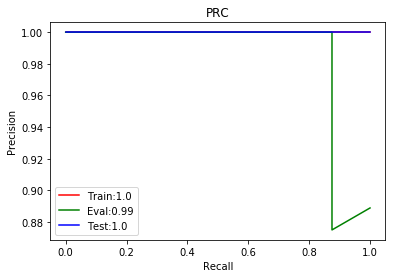

In [26]:
## PRC 
## PRC only valid for binary outcomes. 
## Editing levels < 0.4 are labeled as "0". 
## Editing levels >= 0.4 are labeled as "1". 

from sklearn.metrics import auc, precision_recall_curve

precision_train,recall_train,prc_thresholds_train=precision_recall_curve(train_y>=0.4,train_pred)
precision_eval,recall_eval,prc_thresholds_eval=precision_recall_curve(eval_y>=0.4,eval_pred)
precision_test,recall_test,prc_thresholds_test=precision_recall_curve(test_y>=0.4,test_pred)

auprc_train=auc(recall_train,precision_train)
auprc_eval=auc(recall_eval,precision_eval)
auprc_test=auc(recall_test,precision_test)

plt.plot(recall_train,precision_train,'r',label="Train:"+str(round(auprc_train,2)))
plt.plot(recall_eval,precision_eval,'g',label="Eval:"+str(round(auprc_eval,2)))
plt.plot(recall_test,precision_test,'b',label="Test:"+str(round(auprc_test,2)))
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("PRC")
plt.legend()

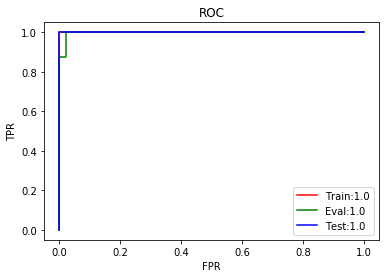

In [27]:
## ROC
from sklearn.metrics import roc_curve, roc_auc_score
fpr_train,tpr_train,roc_thresholds_train=roc_curve(train_y>=0.4,train_pred)
fpr_eval,tpr_eval,roc_thresholds_eval=roc_curve(eval_y>=0.4,eval_pred)
fpr_test,tpr_test,roc_thresholds_test=roc_curve(test_y>=0.4,test_pred)

auroc_train=roc_auc_score(train_y>=0.4,train_pred)
auroc_eval=roc_auc_score(eval_y>=0.4,eval_pred)
auroc_test=roc_auc_score(test_y>=0.4,test_pred)

plt.plot(fpr_train,tpr_train,'r',label="Train:"+str(round(auroc_train,2)))
plt.plot(fpr_eval,tpr_eval,'g',label="Eval:"+str(round(auroc_eval,2)))
plt.plot(fpr_test,tpr_test,'b',label="Test:"+str(round(auroc_test,2)))
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC")
plt.legend()

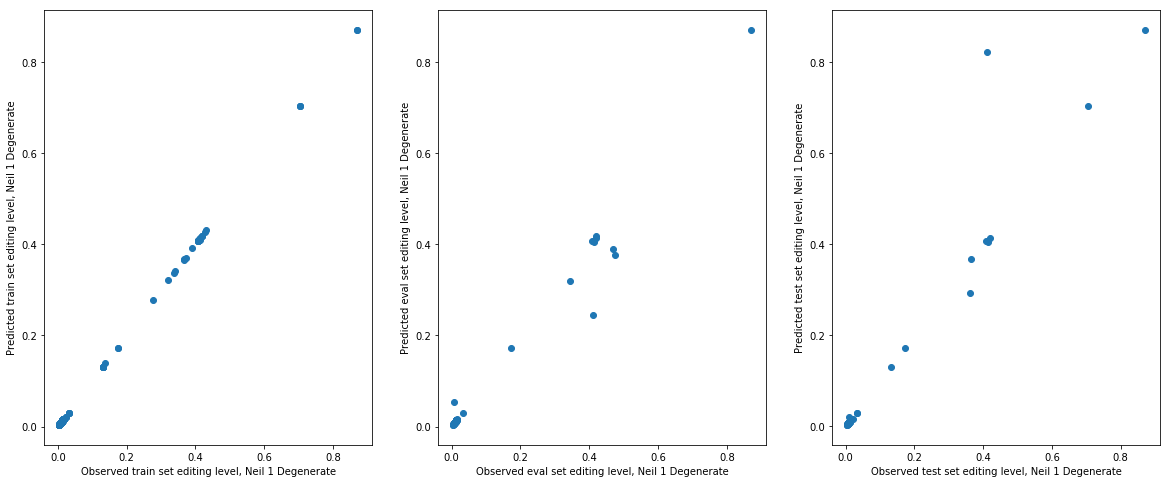

In [28]:
#plot the test set predictions 
matplotlib.rcParams['figure.figsize'] = [20, 8]
plt.subplot(1,3,1)
plt.plot(list(train_y),list(train_pred),'o')
plt.xlabel("Observed train set editing level, Neil 1 Degenerate")
plt.ylabel("Predicted train set editing level, Neil 1 Degenerate")
plt.subplot(1,3,2)
plt.plot(list(eval_y),list(eval_pred),'o')
plt.xlabel("Observed eval set editing level, Neil 1 Degenerate")
plt.ylabel("Predicted eval set editing level, Neil 1 Degenerate")
plt.subplot(1,3,3)
plt.plot(list(test_y),list(test_pred),'o')
plt.xlabel("Observed test set editing level, Neil 1 Degenerate")
plt.ylabel("Predicted test set editing level, Neil 1 Degenerate")

plt.show()

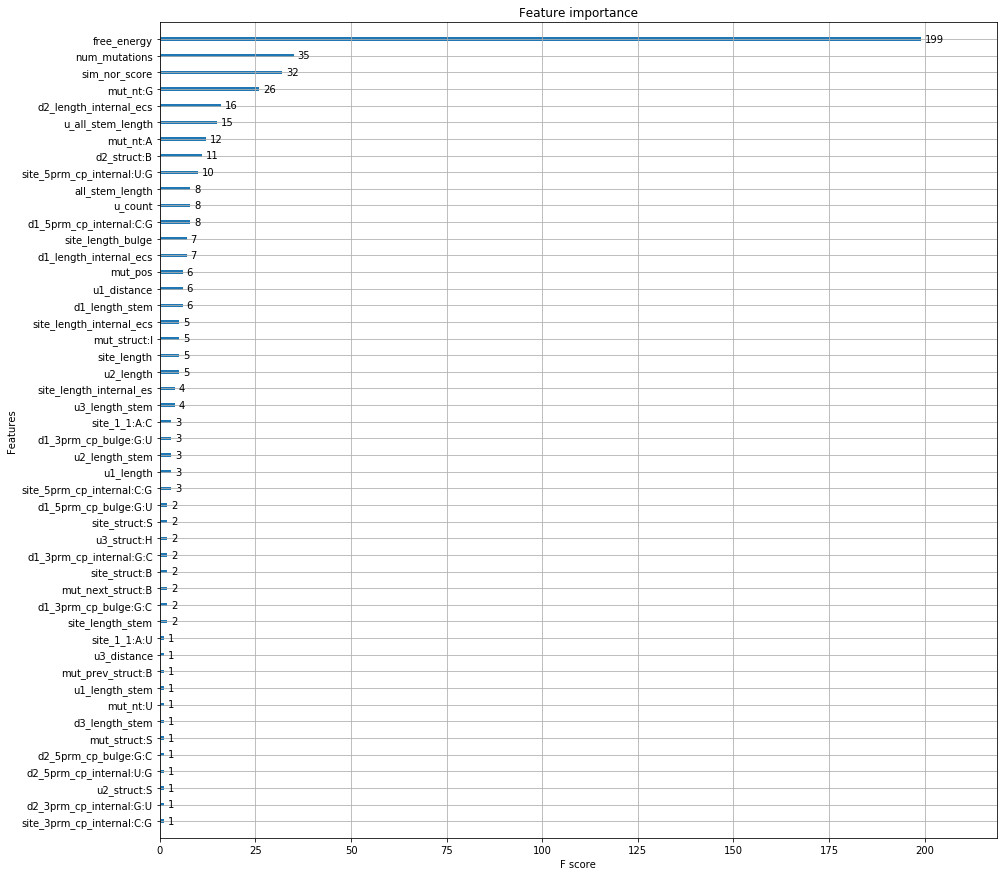

In [29]:
matplotlib.rcParams['figure.figsize'] = [15, 15]
xgboost.plot_importance(bst)

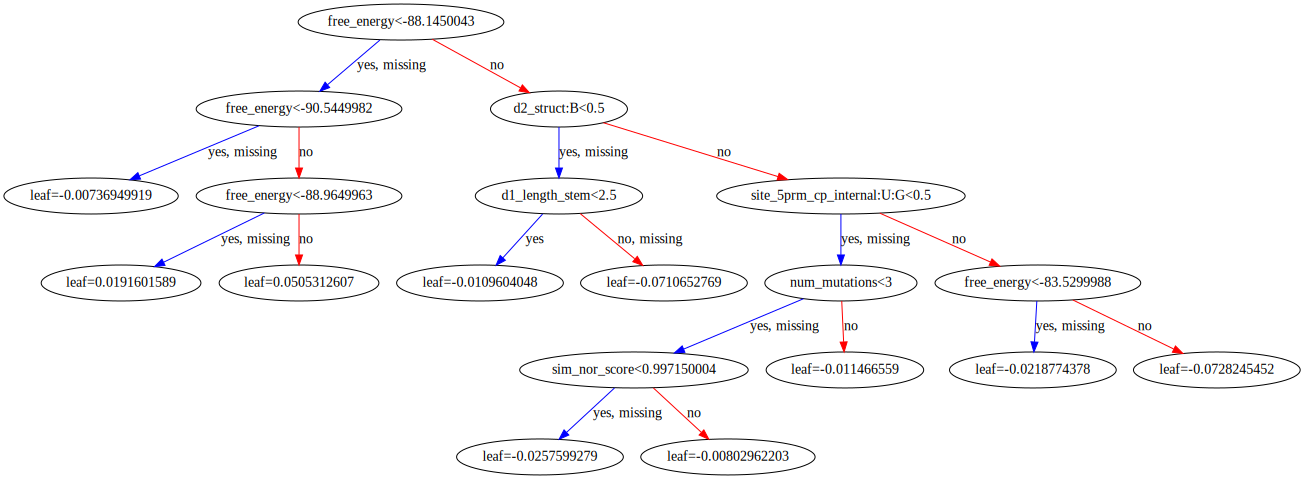

In [30]:
xgboost.to_graphviz(bst, num_trees=2)


In [31]:
# explain the model's predictions using SHAP values
explainer = shap.TreeExplainer(bst)
shap_values = explainer.shap_values(test_X)
shap_values.shape

(67, 106)

In [32]:
test_y=pd.DataFrame(test_y)
max_index=test_y.index[test_y['editing_value'] == max(test_y['editing_value'])]
max_row=test_y.index.get_loc(max_index[0])
# visualize prediction for isoform with the highest editing level 
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[max_row,:], test_X.iloc[max_row,:])

In [33]:
# visualize prediction for isoform with the lowest editing level 
shap.initjs()
min_index=test_y.index[test_y['editing_value'] == min(test_y['editing_value'])]
min_row=test_y.index.get_loc(min_index[0])
shap.force_plot(explainer.expected_value, shap_values[min_row,:], test_X.iloc[min_row,:])

In [34]:
# visualize the training set predictions
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values,train_X)

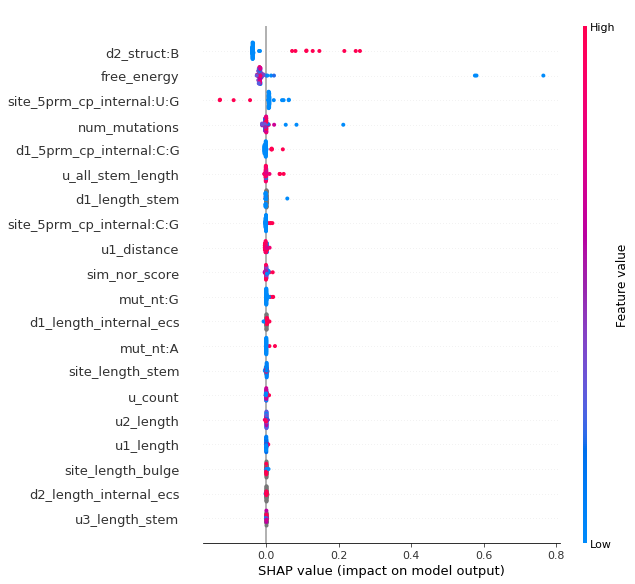

In [35]:
# summarize the effect of all the features 
shap.summary_plot(shap_values, test_X)


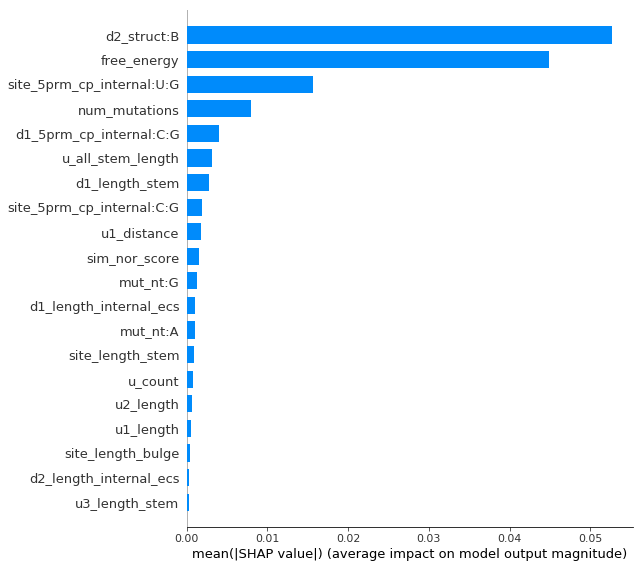

In [36]:
# We can also just take the mean absolute value of the SHAP values for each feature 
# to get a standard bar plot (produces stacked bars for multi-class outputs):
shap.summary_plot(shap_values, test_X, plot_type="bar")

In [37]:
## Compute pairwise interaction values from TreeShap
shap_interaction_values=explainer.shap_interaction_values(test_X)
shap_interaction_values.shape

(67, 106, 106)

In [38]:
##Average interaction values across the datapoints in the test set 
mean_interaction_values=np.mean(shap_interaction_values,axis=0)

In [39]:
Index=test_X.columns
Cols=test_X.columns
mean_interaction_values_df = pd.DataFrame(mean_interaction_values, index=Index, columns=Cols)

In [40]:
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)
configure_plotly_browser_state()

trace = Heatmap(z=mean_interaction_values_df.values,
                   x=Cols,
                   y=Index)
iplot([trace],show_link=False)


## Degenerate Dataset: Feature Subsets<a name='2'>
<a href=#outline>Home</a>

In [41]:
shap_values=pd.DataFrame(shap_values,columns=Cols)

['num_mutations*', 'mut_pos*', 'mut_site_dist*', 'mut_ref_nt*', 'mut_nt*', 'mut_struct*', 'mut_ref_struct*', 'mut_prev_struct*', 'mut_next_struct*', 'mut_same_as_site*']


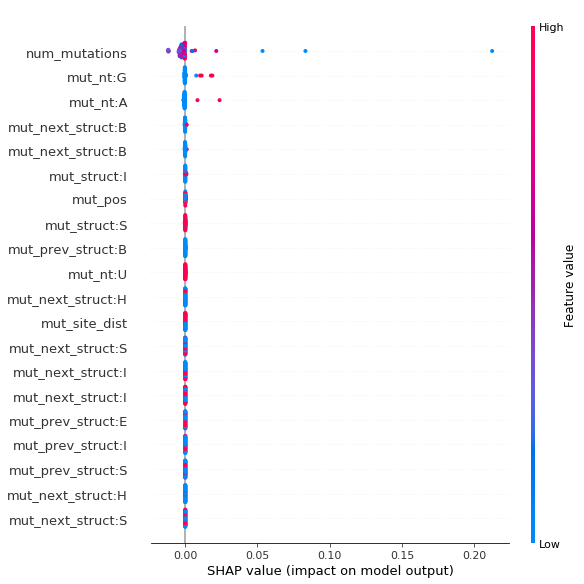

Contribution/Total:0.07362174
['site_prev_nt*', 'site_next_nt*', 'site_struct*', 'site_prev_struct*', 'site_next_struct*', 'site_1_1*', 'site_length*', 'site_length_stem*', 'site_length_hairpin*', 'site_length_bulge*', 'site_length_internal_es*', 'site_length_internal_ecs*', 'site_5prm_cp_hairpin*', 'site_5prm_cp_bulge*', 'site_3prm_cp_bulge*', 'site_5prm_cp_internal*', 'site_3prm_cp_internal*']


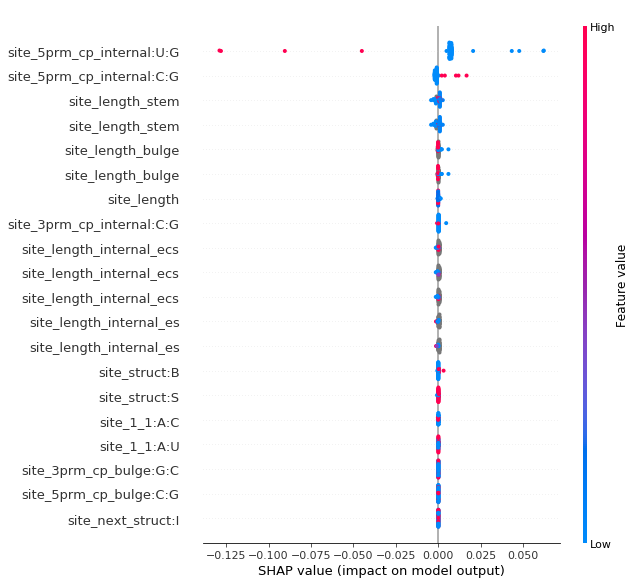

Contribution/Total:0.1495757
['u_count*', 'u_all_stem_length*', 'u_hairpin_length*', 'u1_exist*', 'u1_distance*', 'u1_struct*', 'u1_length*', 'u1_length_stem*', 'u1_length_hairpin*', 'u1_length_bulge*', 'u1_length_internal_es*', 'u1_length_internal_ecs*', 'u1_5prm_cp_hairpin*', 'u1_5prm_cp_bulge*', 'u1_3prm_cp_bulge*', 'u1_5prm_cp_internal*', 'u1_3prm_cp_internal*', 'u2_exist*', 'u2_distance*', 'u2_struct*', 'u2_length*', 'u2_length_stem*', 'u2_length_hairpin*', 'u2_length_bulge*', 'u2_length_internal_es*', 'u2_length_internal_ecs*', 'u2_5prm_cp_hairpin*', 'u2_5prm_cp_bulge*', 'u2_3prm_cp_bulge*', 'u2_5prm_cp_internal*', 'u2_3prm_cp_internal*', 'u3_exist*', 'u3_distance*', 'u3_struct*', 'u3_length*', 'u3_length_stem*', 'u3_length_hairpin*', 'u3_length_bulge*', 'u3_length_internal_es*', 'u3_length_internal_ecs*', 'u3_5prm_cp_hairpin*', 'u3_5prm_cp_bulge*', 'u3_3prm_cp_bulge*', 'u3_5prm_cp_internal*', 'u3_3prm_cp_internal*']


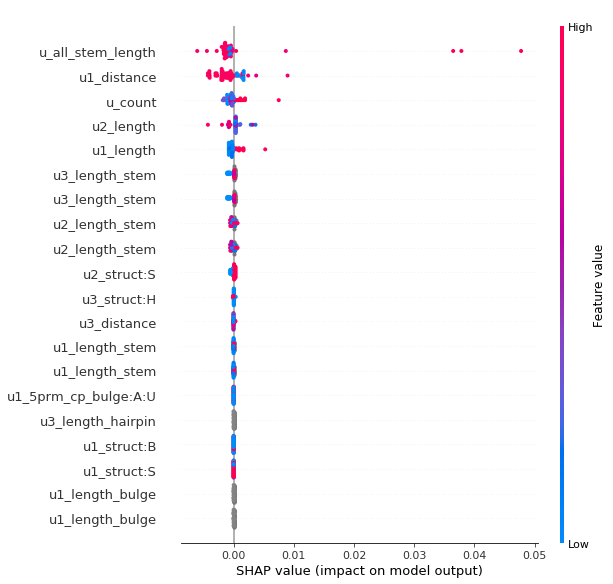

Contribution/Total:0.055902228
['d_count*', 'd_all_stem_length*', 'd1_exist*', 'd1_distance*', 'd1_struct*', 'd1_length*', 'd1_length_stem*', 'd1_length_hairpin*', 'd1_length_bulge*', 'd1_length_internal_es*', 'd1_length_internal_ecs*', 'd1_5prm_cp_hairpin*', 'd1_5prm_cp_bulge*', 'd1_3prm_cp_bulge*', 'd1_5prm_cp_internal*', 'd1_3prm_cp_internal*', 'd2_exist*', 'd2_distance*', 'd2_struct*', 'd2_length*', 'd2_length_stem*', 'd2_length_hairpin*', 'd2_length_bulge*', 'd2_length_internal_es*', 'd2_length_internal_ecs*', 'd2_5prm_cp_hairpin*', 'd2_5prm_cp_bulge*', 'd2_3prm_cp_bulge*', 'd2_5prm_cp_internal*', 'd2_3prm_cp_internal*', 'd3_exist*', 'd3_distance*', 'd3_struct*', 'd3_length*', 'd3_length_stem*', 'd3_length_hairpin*', 'd3_length_bulge*', 'd3_length_internal_es*', 'd3_length_internal_ecs*', 'd3_5prm_cp_hairpin*', 'd3_5prm_cp_bulge*', 'd3_3prm_cp_bulge*', 'd3_5prm_cp_internal*', 'd3_3prm_cp_internal*']


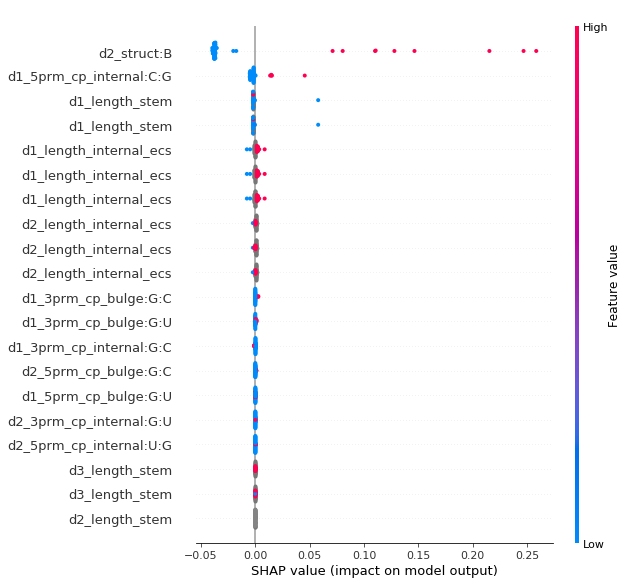

Contribution/Total:0.45796895
['u_count*', 'u_all_stem_length*', 'u_hairpin_length*', 'u1_exist*', 'u1_distance*', 'u1_struct*', 'u1_length*', 'u1_length_stem*', 'u1_length_hairpin*', 'u1_length_bulge*', 'u1_length_internal_es*', 'u1_length_internal_ecs*', 'u1_5prm_cp_hairpin*', 'u1_5prm_cp_bulge*', 'u1_3prm_cp_bulge*', 'u1_5prm_cp_internal*', 'u1_3prm_cp_internal*', 'u2_exist*', 'u2_distance*', 'u2_struct*', 'u2_length*', 'u2_length_stem*', 'u2_length_hairpin*', 'u2_length_bulge*', 'u2_length_internal_es*', 'u2_length_internal_ecs*', 'u2_5prm_cp_hairpin*', 'u2_5prm_cp_bulge*', 'u2_3prm_cp_bulge*', 'u2_5prm_cp_internal*', 'u2_3prm_cp_internal*', 'u3_exist*', 'u3_distance*', 'u3_struct*', 'u3_length*', 'u3_length_stem*', 'u3_length_hairpin*', 'u3_length_bulge*', 'u3_length_internal_es*', 'u3_length_internal_ecs*', 'u3_5prm_cp_hairpin*', 'u3_5prm_cp_bulge*', 'u3_3prm_cp_bulge*', 'u3_5prm_cp_internal*', 'u3_3prm_cp_internal*', 'd_count*', 'd_all_stem_length*', 'd1_exist*', 'd1_distance*',

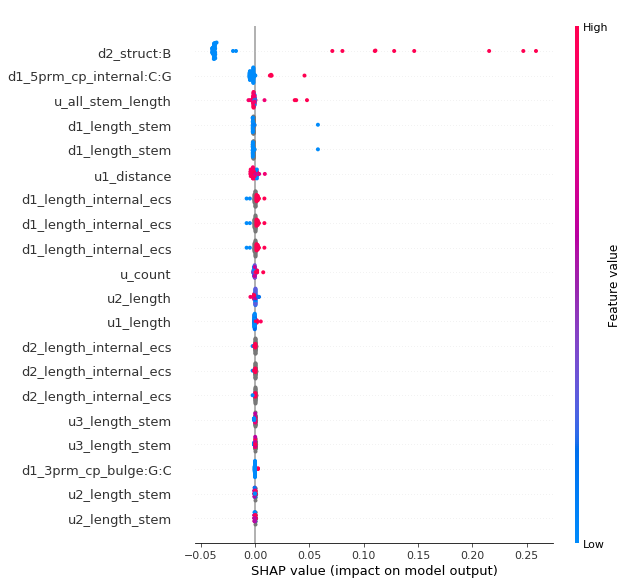

Contribution/Total:0.51387125
['num_mutations*', 'mut_pos*', 'mut_site_dist*', 'mut_ref_nt*', 'mut_nt*', 'mut_struct*', 'mut_ref_struct*', 'mut_prev_struct*', 'mut_next_struct*', 'mut_same_as_site*', 'site_prev_nt*', 'site_next_nt*', 'site_struct*', 'site_prev_struct*', 'site_next_struct*', 'site_1_1*', 'site_length*', 'site_length_stem*', 'site_length_hairpin*', 'site_length_bulge*', 'site_length_internal_es*', 'site_length_internal_ecs*', 'site_5prm_cp_hairpin*', 'site_5prm_cp_bulge*', 'site_3prm_cp_bulge*', 'site_5prm_cp_internal*', 'site_3prm_cp_internal*']


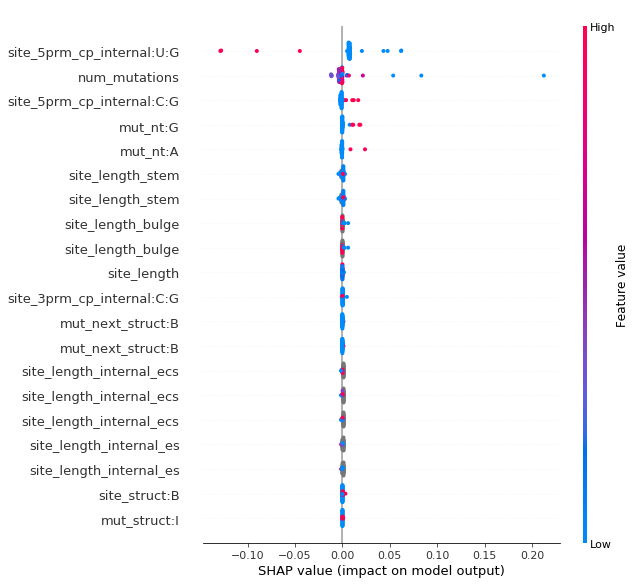

Contribution/Total:0.22319745
['all_stem_length', 'free_energy*', 'sim_nor_score*', 'probability_active_conf*', 'num_mutations*', 'mut_pos*', 'mut_site_dist*', 'mut_ref_nt*', 'mut_nt*', 'mut_struct*', 'mut_ref_struct*', 'mut_prev_struct*', 'mut_next_struct*', 'mut_same_as_site*', 'site_prev_nt*', 'site_next_nt*', 'site_struct*', 'site_prev_struct*', 'site_next_struct*', 'site_1_1*', 'site_length*', 'site_length_stem*', 'site_length_hairpin*', 'site_length_bulge*', 'site_length_internal_es*', 'site_length_internal_ecs*', 'site_5prm_cp_hairpin*', 'site_5prm_cp_bulge*', 'site_3prm_cp_bulge*', 'site_5prm_cp_internal*', 'site_3prm_cp_internal*', 'd_count*', 'd_all_stem_length*', 'd1_exist*', 'd1_distance*', 'd1_struct*', 'd1_length*', 'd1_length_stem*', 'd1_length_hairpin*', 'd1_length_bulge*', 'd1_length_internal_es*', 'd1_length_internal_ecs*', 'd1_5prm_cp_hairpin*', 'd1_5prm_cp_bulge*', 'd1_3prm_cp_bulge*', 'd1_5prm_cp_internal*', 'd1_3prm_cp_internal*', 'd2_exist*', 'd2_distance*', 'd2_

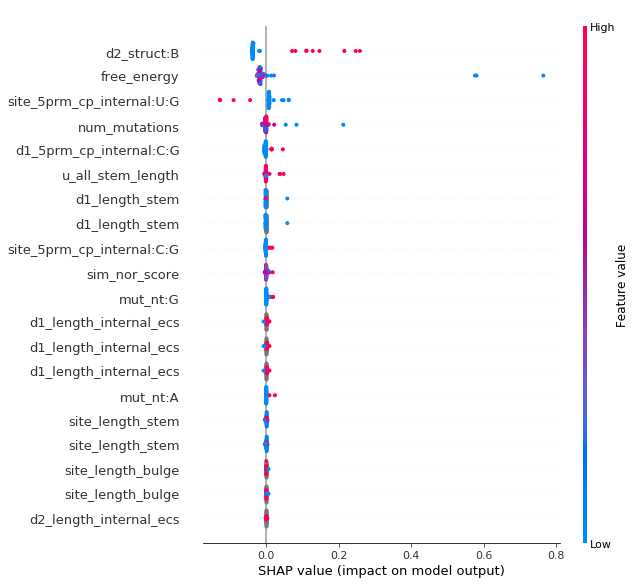

Contribution/Total:1.0207719
['all_stem_length', 'free_energy*', 'sim_nor_score*', 'probability_active_conf*', 'num_mutations*', 'mut_pos*', 'mut_site_dist*', 'mut_ref_nt*', 'mut_nt*', 'mut_struct*', 'mut_ref_struct*', 'mut_prev_struct*', 'mut_next_struct*', 'mut_same_as_site*', 'site_prev_nt*', 'site_next_nt*', 'site_struct*', 'site_prev_struct*', 'site_next_struct*', 'site_1_1*', 'site_length*', 'site_length_stem*', 'site_length_hairpin*', 'site_length_bulge*', 'site_length_internal_es*', 'site_length_internal_ecs*', 'site_5prm_cp_hairpin*', 'site_5prm_cp_bulge*', 'site_3prm_cp_bulge*', 'site_5prm_cp_internal*', 'site_3prm_cp_internal*', 'u_count*', 'u_all_stem_length*', 'u_hairpin_length*', 'u1_exist*', 'u1_distance*', 'u1_struct*', 'u1_length*', 'u1_length_stem*', 'u1_length_hairpin*', 'u1_length_bulge*', 'u1_length_internal_es*', 'u1_length_internal_ecs*', 'u1_5prm_cp_hairpin*', 'u1_5prm_cp_bulge*', 'u1_3prm_cp_bulge*', 'u1_5prm_cp_internal*', 'u1_3prm_cp_internal*', 'u2_exist*', 

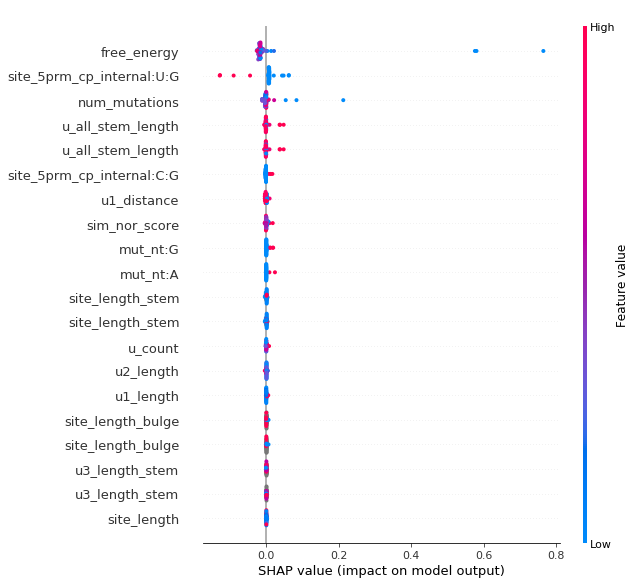

Contribution/Total:0.6187049
['site_struct*', 'site_prev_struct*', 'site_next_struct*', 'site_1_1*', 'site_length*', 'site_length_stem*', 'site_length_hairpin*', 'site_length_bulge*', 'site_length_internal_es*', 'site_length_internal_ecs*', 'site_5prm_cp_hairpin*', 'site_5prm_cp_bulge*', 'site_3prm_cp_bulge*', 'site_5prm_cp_internal*', 'site_3prm_cp_internal*']


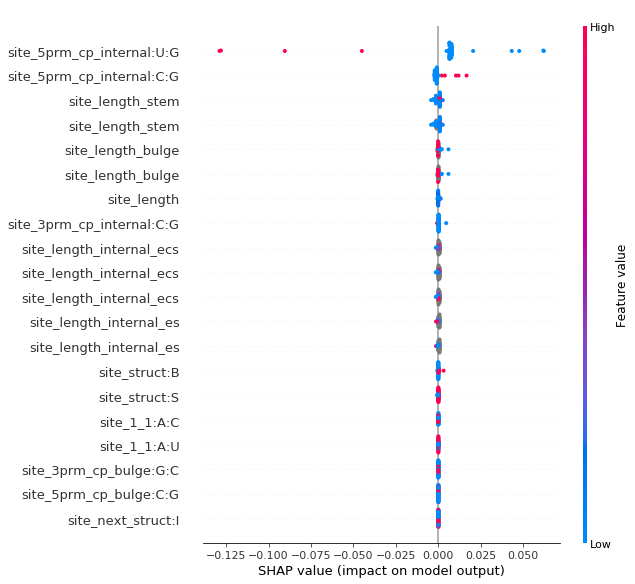

Contribution/Total:0.1495757
['site_prev_nt*', 'site_next_nt*']


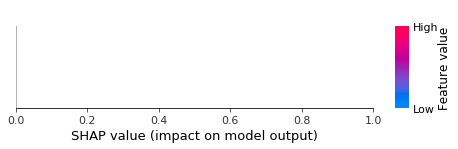

Contribution/Total:0.0
['mut_pos*', 'mut_site_dist*', 'mut_ref_nt*', 'mut_nt*']


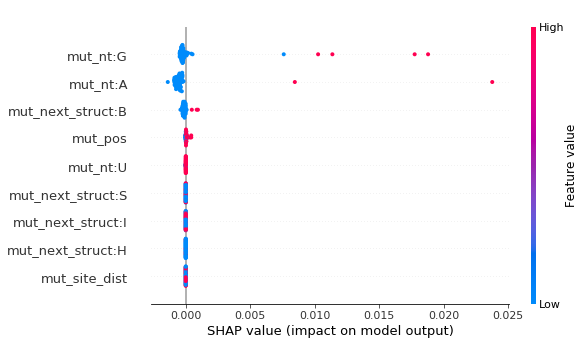

Contribution/Total:0.016834691
['mut_pos*', 'mut_site_dist*', 'mut_ref_nt*', 'mut_nt*', 'site_prev_nt*', 'site_next_nt*']


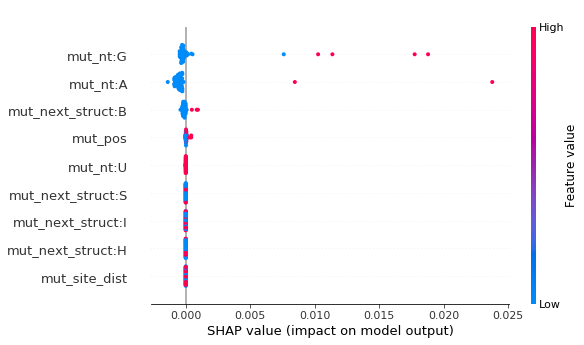

Contribution/Total:0.016834691
['all_stem_length', 'free_energy*', 'sim_nor_score*', 'probability_active_conf*', 'site_prev_nt*', 'site_next_nt*', 'site_struct*', 'site_prev_struct*', 'site_next_struct*', 'site_1_1*', 'site_length*', 'site_length_stem*', 'site_length_hairpin*', 'site_length_bulge*', 'site_length_internal_es*', 'site_length_internal_ecs*', 'site_5prm_cp_hairpin*', 'site_5prm_cp_bulge*', 'site_3prm_cp_bulge*', 'site_5prm_cp_internal*', 'site_3prm_cp_internal*', 'u_count*', 'u_all_stem_length*', 'u_hairpin_length*', 'u1_exist*', 'u1_distance*', 'u1_struct*', 'u1_length*', 'u1_length_stem*', 'u1_length_hairpin*', 'u1_length_bulge*', 'u1_length_internal_es*', 'u1_length_internal_ecs*', 'u1_5prm_cp_hairpin*', 'u1_5prm_cp_bulge*', 'u1_3prm_cp_bulge*', 'u1_5prm_cp_internal*', 'u1_3prm_cp_internal*', 'u2_exist*', 'u2_distance*', 'u2_struct*', 'u2_length*', 'u2_length_stem*', 'u2_length_hairpin*', 'u2_length_bulge*', 'u2_length_internal_es*', 'u2_length_internal_ecs*', 'u2_5prm_

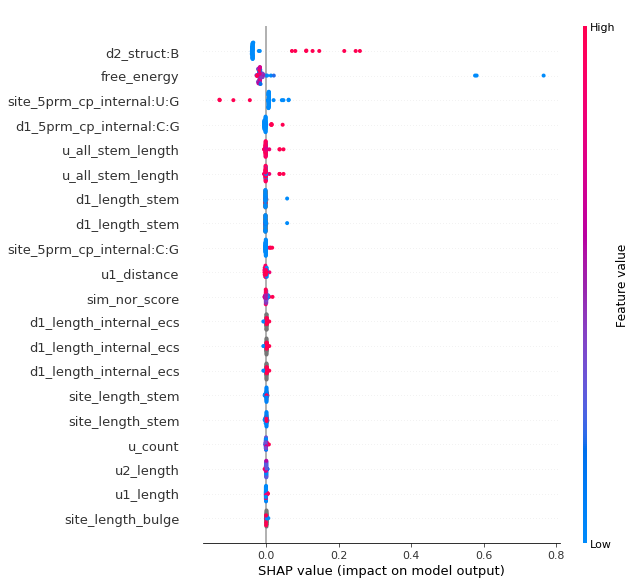

Contribution/Total:1.0030522
['all_stem_length', 'free_energy*', 'sim_nor_score*', 'probability_active_conf*']


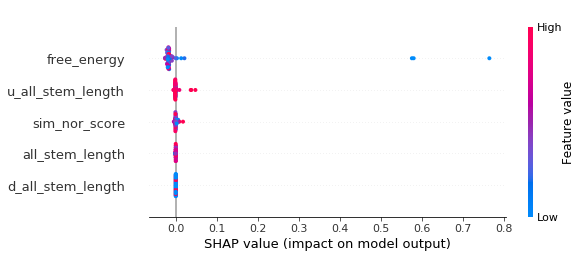

Contribution/Total:0.3396053


In [42]:
from feature_subsets import * 
for subset in [mut,site,u,d,u_d,mut_site,no_up,no_down,site_struct,site_seq,mut_seq,mut_seq_site,no_mut,overall_structure]: 
  print(subset)
  cur_features=filter_features(shap_values,subset)
  cur_feature_shap=shap_values[cur_features].values 
  cur_feature_test_X=test_X[cur_features]
  shap.summary_plot(cur_feature_shap, cur_feature_test_X)#,sort=False,max_display=50)
  print("Contribution/Total:"+str(shap_contribs_subgroup(shap_values,subset)))

## Neil1 Computational features <a name='3'>
<a href=#outline>Home</a>

In [43]:
data=pd.read_csv("../xin_feature_matrices/ttyh2_computational.features.csv",header=0,sep=',',index_col=0)

In [44]:
#remove any null editing level values 
data=data[~data["editing_value"].isnull().values]

In [45]:
data=format_for_xgboost(data)
train_split,eval_split,test_split=split_train_test_eval_by_mut_pos(data)

(601, 216)
{21.0: 18, 22.0: 18, 23.0: 18, 24.0: 20, 25.0: 17, 26.0: 20, 27.0: 20, 28.0: 20, 29.0: 18, 30.0: 18, 31.0: 17, 32.0: 17, 33.0: 17, 34.0: 18, 35.0: 18, 36.0: 18, 79.0: 17, 80.0: 17, 81.0: 18, 82.0: 18, 83.0: 19, 84.0: 19, 85.0: 20, 86.0: 29, 88.0: 27, 89.0: 18, 90.0: 17, 91.0: 17, 92.0: 17, 93.0: 14, 94.0: 18, 95.0: 18, nan: 0, nan: 0, nan: 0, nan: 0, nan: 6}


In [46]:
#Remove any non-varying features 
train_novar=get_singleval_features(train_split)
eval_novar=get_singleval_features(eval_split)
test_novar=get_singleval_features(test_split)
uniform_features_to_drop=list(set(train_novar+eval_novar+test_novar))

In [47]:
#Remove any null features 
train_null=get_all_null_features(train_split)
eval_null=get_all_null_features(eval_split)
test_null=get_all_null_features(test_split)
null_features_to_drop=list(set(train_null+eval_null+test_null))

In [48]:
to_drop=list(set(uniform_features_to_drop+null_features_to_drop))
print("\n".join(to_drop))

d3_length_internal_es
u1_5prm_cp_internal
mut_ref_struct:B
u2_5prm_cp_bulge:C:G
mut_struct:B
mut_ref_struct:S
u3_5prm_cp_bulge:C:G
mut_next_struct:E
mut_ref_nt:A
d2_3prm_cp_internal:C:G
d1_5prm_cp_bulge:G:U
u1_length_hairpin
d1_5prm_cp_bulge:A:U
d2_length_hairpin
d3_5prm_cp_internal:G:C
site_5prm_cp_internal:U:G
u2_3prm_cp_bulge:G:C
site_next_nt:U
mut_ref_nt:C
u1_3prm_cp_internal
d3_struct:B
site_prev_nt:U
mut_same_as_site
u3_exist
site_3prm_cp_bulge:G:U
d3_3prm_cp_internal:C:G
site_5prm_cp_bulge:U:G
d2_3prm_cp_internal:U:A
site_prev_nt:A
u1_3prm_cp_bulge:A:U
u3_5prm_cp_internal
d2_5prm_cp_hairpin
u3_5prm_cp_bulge:A:U
d3_5prm_cp_bulge:G:C
d1_3prm_cp_bulge:G:U
site_1_1:A:U
d2_5prm_cp_internal:U:G
u3_5prm_cp_bulge:G:C
u2_length_internal_es
site_next_nt:A
u2_length_internal_ecs
d2_exist
u1_length_internal_es
d1_exist
site_3prm_cp_bulge:C:G
d3_length_hairpin
d3_3prm_cp_internal:U:A
d3_struct:I
mut_ref_struct:I
d1_5prm_cp_bulge:C:G
u3_length_internal_ecs
mut_type:mismatch
d1_5prm_cp_interna

In [49]:
train_split=train_split.drop(to_drop,axis=1)
eval_split=eval_split.drop(to_drop,axis=1)
test_split=test_split.drop(to_drop,axis=1)

In [50]:
train_y=train_split['editing_value']
train_X=train_split.drop(['editing_value'],axis=1)

eval_y=eval_split['editing_value']
eval_X=eval_split.drop(['editing_value'],axis=1)

test_y=test_split['editing_value']
test_X=test_split.drop(['editing_value'],axis=1)

In [51]:
print(train_X.shape)
print(train_y.shape)
print(eval_X.shape)
print(eval_y.shape)
print(test_X.shape)
print(test_y.shape)


(415, 123)
(415,)
(71, 123)
(71,)
(121, 123)
(121,)


In [52]:
## format matrixes for xgboost 
dtrain=xgboost.DMatrix(train_X,train_y)
deval=xgboost.DMatrix(eval_X,eval_y)
dtest=xgboost.DMatrix(test_X,test_y)

In [53]:
## set model training parameters 
param=dict() 
param['nthread'] = 20
#rmse -- root mean square error 
# mae -- mean absolute error 
# map -- mean average precision 
# auc -- area under ROC curve 
# aucpr -- area under precision recall curve 
param['eval_metric'] = ['auc','mae','map','aucpr','rmse']

In [54]:
evallist = [(deval, 'eval'), (dtrain, 'train')]


In [55]:
num_round = 1000
bst = xgboost.train(param, dtrain, num_round, evallist,early_stopping_rounds=10)

[0]	eval-auc:0.659168	eval-mae:0.230055	eval-map:1	eval-aucpr:0.268041	eval-rmse:0.245078	train-auc:0.720915	train-mae:0.244615	train-map:1	train-aucpr:0.322509	train-rmse:0.264417
Multiple eval metrics have been passed: 'train-rmse' will be used for early stopping.

Will train until train-rmse hasn't improved in 10 rounds.
[1]	eval-auc:0.663261	eval-mae:0.168891	eval-map:1	eval-aucpr:0.268771	eval-rmse:0.182806	train-auc:0.736776	train-mae:0.173848	train-map:1	train-aucpr:0.333541	train-rmse:0.191582
[2]	eval-auc:0.677166	eval-mae:0.126923	eval-map:1	eval-aucpr:0.269654	eval-rmse:0.140558	train-auc:0.755035	train-mae:0.124395	train-map:1	train-aucpr:0.341185	train-rmse:0.1396
[3]	eval-auc:0.686333	eval-mae:0.099199	eval-map:1	eval-aucpr:0.276773	eval-rmse:0.112778	train-auc:0.762416	train-mae:0.090286	train-map:1	train-aucpr:0.344054	train-rmse:0.103482
[4]	eval-auc:0.696296	eval-mae:0.078291	eval-map:1	eval-aucpr:0.28684	eval-rmse:0.092962	train-auc:0.766287	train-mae:0.066128	train-

[45]	eval-auc:0.712521	eval-mae:0.029973	eval-map:1	eval-aucpr:0.323821	eval-rmse:0.05513	train-auc:0.779157	train-mae:0.004105	train-map:1	train-aucpr:0.354973	train-rmse:0.005683
[46]	eval-auc:0.712455	eval-mae:0.029943	eval-map:1	eval-aucpr:0.323649	eval-rmse:0.05504	train-auc:0.779165	train-mae:0.003964	train-map:1	train-aucpr:0.354977	train-rmse:0.005523
[47]	eval-auc:0.713072	eval-mae:0.029629	eval-map:1	eval-aucpr:0.328835	eval-rmse:0.054913	train-auc:0.779184	train-mae:0.00383	train-map:1	train-aucpr:0.354998	train-rmse:0.005311
[48]	eval-auc:0.713379	eval-mae:0.029256	eval-map:1	eval-aucpr:0.329089	eval-rmse:0.054622	train-auc:0.779211	train-mae:0.003602	train-map:1	train-aucpr:0.355018	train-rmse:0.004977
[49]	eval-auc:0.713338	eval-mae:0.029285	eval-map:1	eval-aucpr:0.329041	eval-rmse:0.054671	train-auc:0.779227	train-mae:0.003436	train-map:1	train-aucpr:0.355088	train-rmse:0.004764
[50]	eval-auc:0.713801	eval-mae:0.029046	eval-map:1	eval-aucpr:0.330721	eval-rmse:0.05463	tra

Stopping. Best iteration:
[80]	eval-auc:0.713949	eval-mae:0.027711	eval-map:1	eval-aucpr:0.327787	eval-rmse:0.053953	train-auc:0.779412	train-mae:0.001077	train-map:1	train-aucpr:0.355267	train-rmse:0.00158



In [57]:
# save to binary file for faster loading
bst.save_model('ttyh2.computational.model')
# save model to text file 
bst.dump_model('ttyh2.computational.raw.txt')


In [58]:
## get model predictions on the test, training, and eval splits 
test_pred = bst.predict(dtest)
train_pred=bst.predict(dtrain)
eval_pred=bst.predict(deval)

In [60]:
## Get performance metrics on full dataset 
from helpers import * 
print_aggregate_peformance_metrics(train_y,train_pred,
                                   eval_y,eval_pred,
                                   test_y,test_pred,
                                  positive_thresh_train=0.4,
                                  positive_thresh_eval=0.4,
                                  positive_thresh_test=0.4)

Train
	Spearman corr : SpearmanrResult(correlation=0.9997401352760427, pvalue=0.0)
	Pearson corr : (0.9999296040792132, 0.0)
	MAE : 0.0010771121718331676
	MAPE : 0.014906770398547133
	RMSE : 0.001579903696671172
	auPRC : 1.0
	auROC : 1.0
Eval
	Spearman corr : SpearmanrResult(correlation=0.9491838060539768, pvalue=2.2904286787608752e-36)
	Pearson corr : (0.9006332705931758, 1.1266463697398919e-26)
	MAE : 0.027711018736513562
	MAPE : 0.1637990057716323
	RMSE : 0.053953339046378605
	auPRC : 0.75
	auROC : 0.9855072463768115
Test
	Spearman corr : SpearmanrResult(correlation=0.9371986196322397, pvalue=2.8638850009025293e-56)
	Pearson corr : (0.9419695818384386, 2.997098171179775e-58)
	MAE : 0.028902060380651934
	MAPE : 0.5424903293974412
	RMSE : 0.04532123082103136
	auPRC : 0.625
	auROC : 0.9747899159663865


In [61]:
## Correlation values 
from scipy.stats import spearmanr,pearsonr
spearman_train=spearmanr(train_y,train_pred)
spearman_eval=spearmanr(eval_y,eval_pred)
spearman_test=spearmanr(test_y,test_pred)

pearson_train=pearsonr(train_y,train_pred)
pearson_eval=pearsonr(eval_y,eval_pred)
pearson_test=pearsonr(test_y,test_pred)

print("Spearman correlation:")
print("Train:"+str(spearman_train))
print("Eval:"+str(spearman_eval))
print("Test:"+str(spearman_test))
print("\n")
print("Pearson correlation:")
print("Train:"+str(pearson_train))
print("Eval:"+str(pearson_eval))
print("Test:"+str(pearson_test))

Spearman correlation:
Train:SpearmanrResult(correlation=0.9997401352760427, pvalue=0.0)
Eval:SpearmanrResult(correlation=0.9491838060539768, pvalue=2.2904286787608752e-36)
Test:SpearmanrResult(correlation=0.9371986196322397, pvalue=2.8638850009025293e-56)


Pearson correlation:
Train:(0.9999296040792132, 0.0)
Eval:(0.9006332705931758, 1.1266463697398919e-26)
Test:(0.9419695818384386, 2.997098171179775e-58)


In [62]:
## MAE
from sklearn.metrics import mean_absolute_error
mae_train=mean_absolute_error(train_y,train_pred)
print("MAE Train:"+str(mae_train))

mae_eval=mean_absolute_error(eval_y,eval_pred)
print("MAE Eval:"+str(mae_eval))

mae_test=mean_absolute_error(test_y,test_pred)
print("MAE Test:"+str(mae_test))


MAE Train:0.0010771121718331676
MAE Eval:0.027711018736513562
MAE Test:0.028902060380651934


In [63]:
## MAPE
pseudocount=0.01
mape_train=np.mean(np.abs((train_y - train_pred) /(pseudocount+train_y))) * 100
print("MAPE Train:"+str(mape_train)+"%")

mape_eval=np.mean(np.abs((eval_y - eval_pred) /(pseudocount+eval_y))) * 100
print("MAPE Eval:"+str(mape_eval)+"%")

mape_test=np.mean(np.abs((test_y - test_pred) /(pseudocount+test_y))) * 100
print("MAPE Test:"+str(mape_test)+"%")

MAPE Train:1.4906770398547133%
MAPE Eval:16.37990057716323%
MAPE Test:54.249032939744126%


In [64]:
## RMSE
from sklearn.metrics import mean_squared_error
import math 
rmse_train=math.sqrt(mean_squared_error(train_y,train_pred))
print("RMSE Train:"+str(rmse_train))

rmse_eval=math.sqrt(mean_squared_error(eval_y,eval_pred))
print("RMSE Eval:"+str(rmse_eval))

rmse_test=math.sqrt(mean_squared_error(test_y,test_pred))
print("RMSE Test:"+str(rmse_test))


RMSE Train:0.001579903696671172
RMSE Eval:0.053953339046378605
RMSE Test:0.04532123082103136


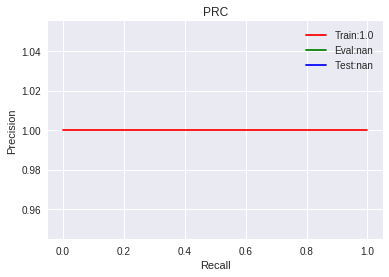

In [27]:
## PRC 
## PRC only valid for binary outcomes. 
## Editing levels < 0.4 are labeled as "0". 
## Editing levels >= 0.4 are labeled as "1". 

from sklearn.metrics import auc, precision_recall_curve

precision_train,recall_train,prc_thresholds_train=precision_recall_curve(train_y>=0.5,train_pred)
precision_eval,recall_eval,prc_thresholds_eval=precision_recall_curve(eval_y>=0.5,eval_pred)
precision_test,recall_test,prc_thresholds_test=precision_recall_curve(test_y>=0.5,test_pred)

auprc_train=auc(recall_train,precision_train)
auprc_eval=auc(recall_eval,precision_eval)
auprc_test=auc(recall_test,precision_test)

plt.plot(recall_train,precision_train,'r',label="Train:"+str(round(auprc_train,2)))
plt.plot(recall_eval,precision_eval,'g',label="Eval:"+str(round(auprc_eval,2)))
plt.plot(recall_test,precision_test,'b',label="Test:"+str(round(auprc_test,2)))
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("PRC")
plt.legend()

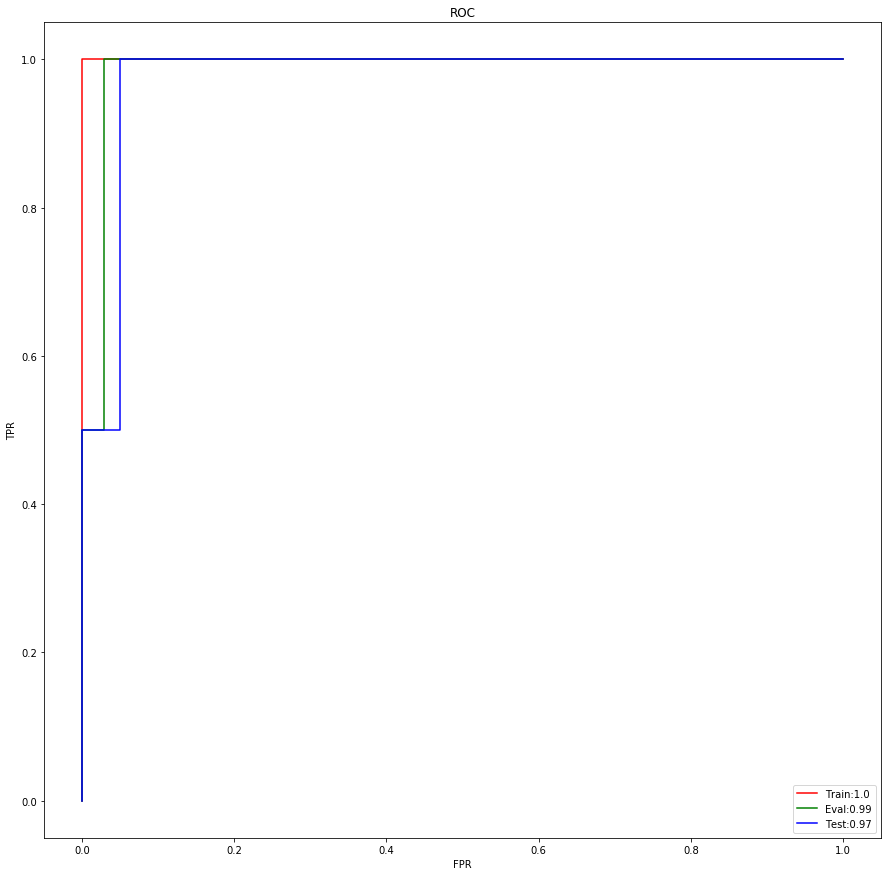

In [66]:
## ROC
from sklearn.metrics import roc_curve, roc_auc_score
fpr_train,tpr_train,roc_thresholds_train=roc_curve(train_y>=0.4,train_pred)
fpr_eval,tpr_eval,roc_thresholds_eval=roc_curve(eval_y>=0.4,eval_pred)
fpr_test,tpr_test,roc_thresholds_test=roc_curve(test_y>=0.4,test_pred)

auroc_train=roc_auc_score(train_y>=0.4,train_pred)
auroc_eval=roc_auc_score(eval_y>=0.4,eval_pred)
auroc_test=roc_auc_score(test_y>=0.4,test_pred)

plt.plot(fpr_train,tpr_train,'r',label="Train:"+str(round(auroc_train,2)))
plt.plot(fpr_eval,tpr_eval,'g',label="Eval:"+str(round(auroc_eval,2)))
plt.plot(fpr_test,tpr_test,'b',label="Test:"+str(round(auroc_test,2)))
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC")
plt.legend()

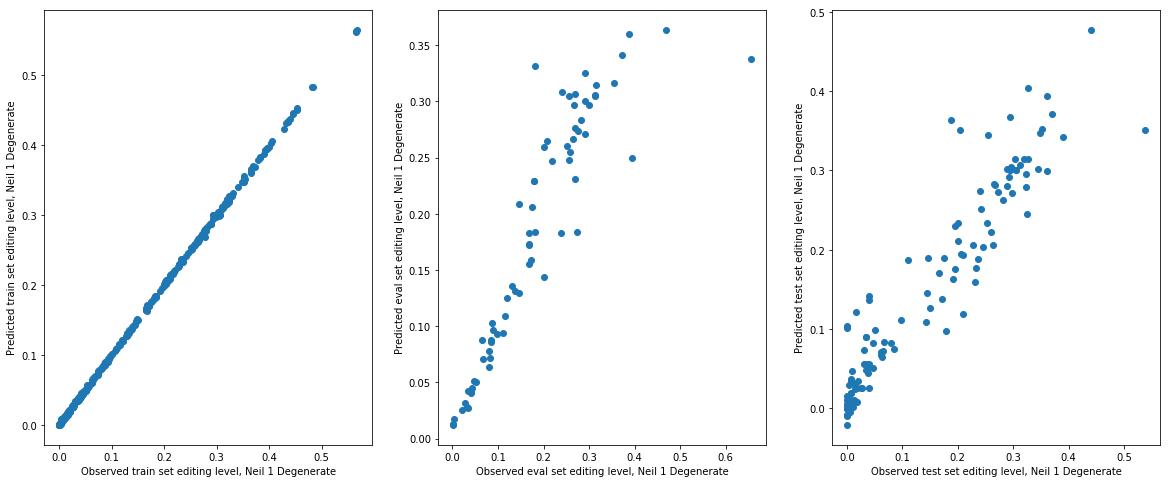

In [67]:
#plot the test set predictions 
matplotlib.rcParams['figure.figsize'] = [20, 8]
plt.subplot(1,3,1)
plt.plot(list(train_y),list(train_pred),'o')
plt.xlabel("Observed train set editing level, Neil 1 Degenerate")
plt.ylabel("Predicted train set editing level, Neil 1 Degenerate")
plt.subplot(1,3,2)
plt.plot(list(eval_y),list(eval_pred),'o')
plt.xlabel("Observed eval set editing level, Neil 1 Degenerate")
plt.ylabel("Predicted eval set editing level, Neil 1 Degenerate")
plt.subplot(1,3,3)
plt.plot(list(test_y),list(test_pred),'o')
plt.xlabel("Observed test set editing level, Neil 1 Degenerate")
plt.ylabel("Predicted test set editing level, Neil 1 Degenerate")

plt.show()

In [68]:
import plotnine
from plotnine import *
test_df=pd.DataFrame({'Observed':test_y,
                     'Predicted':test_pred,
                     'Dataset':'TTYH2_COMP'})

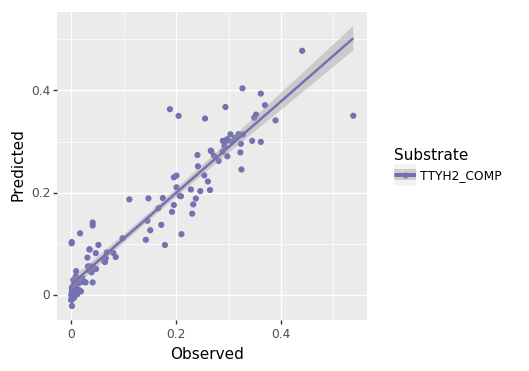

<ggplot: (8773695267697)>


/home/anna/.local/lib/python3.6/site-packages/plotnine/ggplot.py:706: UserWarning:

Saving 4 x 4 in image.

/home/anna/.local/lib/python3.6/site-packages/plotnine/ggplot.py:707: UserWarning:

Filename: TTYH2.comp.substrate.svg



In [69]:
plotnine.options.figure_size = (4, 4)

p=(ggplot(test_df, aes('Observed', 'Predicted', color='factor(Dataset)'))
 + geom_point()
 + stat_smooth(method='lm')
 + scale_color_manual(values=['#7570b3'],name="Substrate"))
print(p)
ggsave(plot=p, filename='TTYH2.comp.substrate.svg',width=4,height=4,units='in')


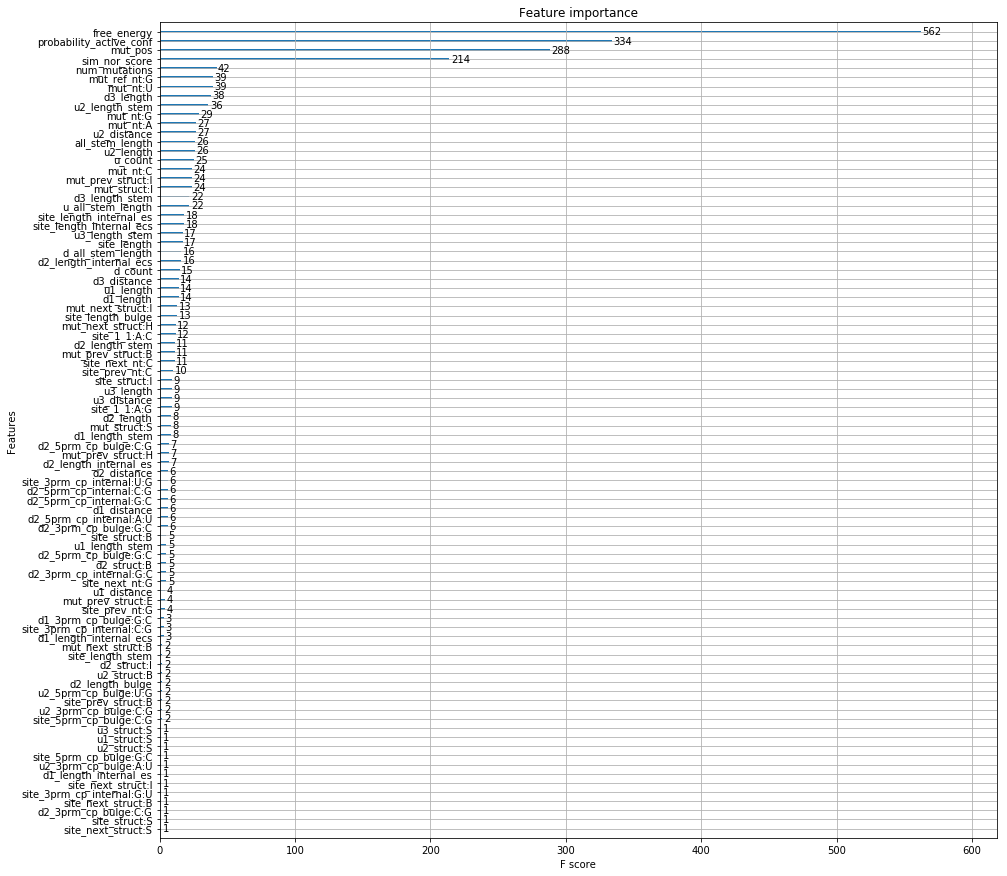

In [70]:
matplotlib.rcParams['figure.figsize'] = [15, 15]
xgboost.plot_importance(bst)

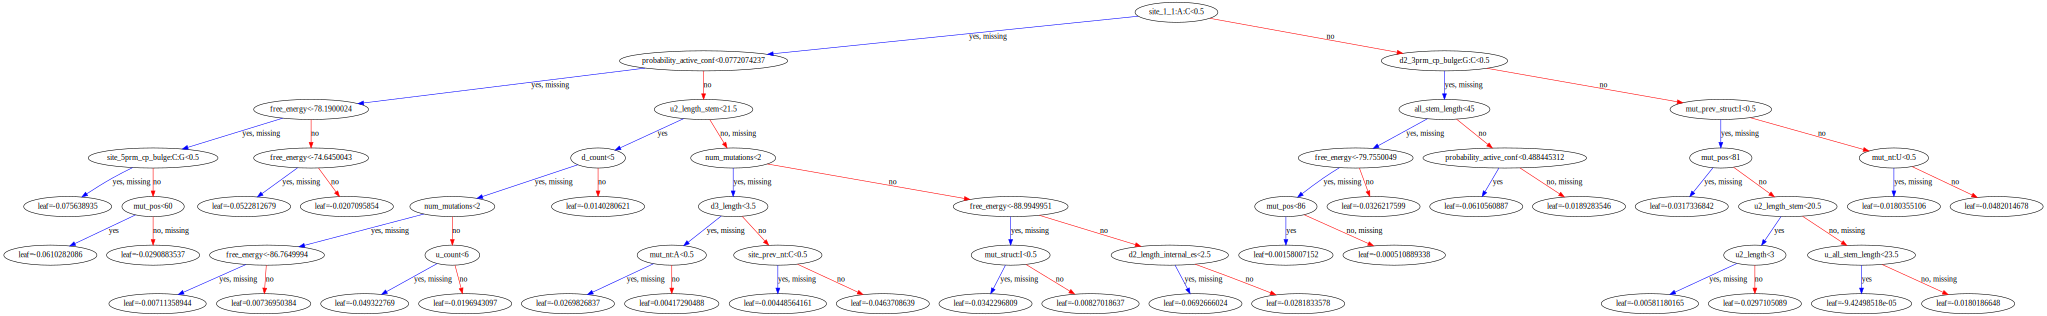

In [71]:
xgboost.to_graphviz(bst, num_trees=2)


In [72]:
# explain the model's predictions using SHAP values
explainer = shap.TreeExplainer(bst)
shap_values = explainer.shap_values(test_X)
shap_values.shape

(121, 123)

In [73]:
test_y=pd.DataFrame(test_y)
max_index=test_y.index[test_y['editing_value'] == max(test_y['editing_value'])]
max_row=test_y.index.get_loc(max_index[0])
# visualize prediction for isoform with the highest editing level 
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[max_row,:], test_X.iloc[max_row,:])

In [74]:
print(max(test_y['editing_value']))
print(test_pred[max_row])

0.5379999999999999
0.35072967


In [75]:
# visualize prediction for isoform with the lowest editing level 
shap.initjs()
min_index=test_y.index[test_y['editing_value'] == min(test_y['editing_value'])]
min_row=test_y.index.get_loc(min_index[0])
shap.force_plot(explainer.expected_value, shap_values[min_row,:], test_X.iloc[min_row,:])

In [76]:
print(min(test_y['editing_value']))
print(test_pred[min_row])

0.0
-0.0088944435


In [77]:
# visualize the training set predictions
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values,train_X)

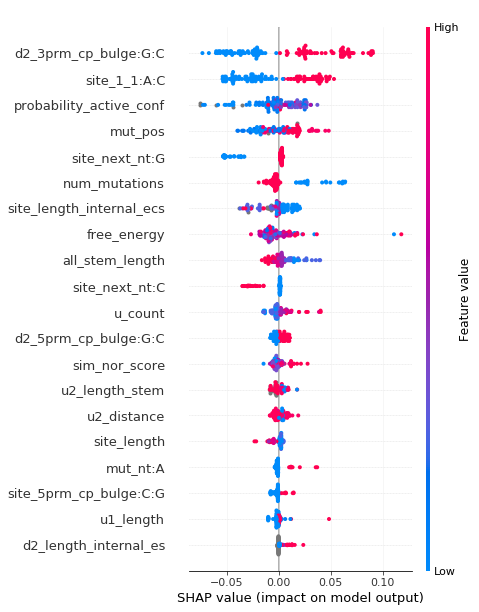

In [78]:
# summarize the effect of all the features 
shap.summary_plot(shap_values, test_X,show=False)
plt.gca().set_facecolor('white')
plt.gca().set_axisbelow(True)
plt.gca().grid(linestyle='-', linewidth='0.5', color='#eeeeee')

plt.gcf().set_size_inches(5, 10)

plt.savefig("TTYH2.comp.shap.svg", format='svg',width=30,height=10,dpi=300,bbox_inches="tight")



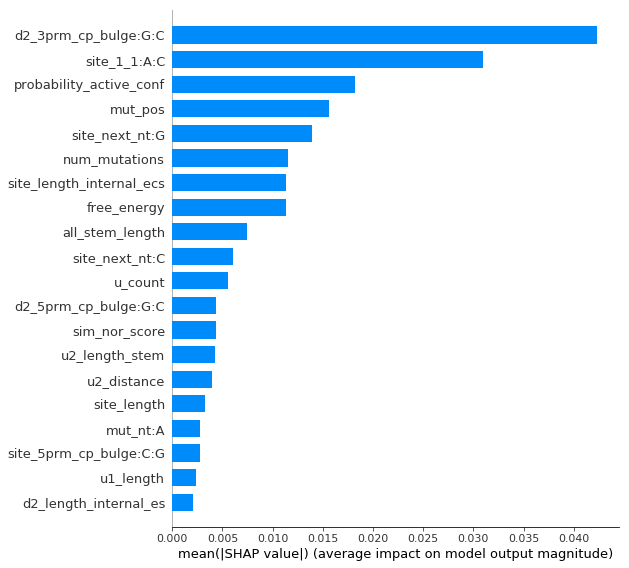

In [79]:
# We can also just take the mean absolute value of the SHAP values for each feature 
# to get a standard bar plot (produces stacked bars for multi-class outputs):
shap.summary_plot(shap_values, test_X, plot_type="bar")

In [80]:
## Compute pairwise interaction values from TreeShap
shap_interaction_values=explainer.shap_interaction_values(test_X)
shap_interaction_values.shape

(121, 123, 123)

In [81]:
##Average interaction values across the datapoints in the test set 
mean_interaction_values=np.mean(shap_interaction_values,axis=0)

In [82]:
Index=test_X.columns
Cols=test_X.columns
mean_interaction_values_df = pd.DataFrame(mean_interaction_values, index=Index, columns=Cols)

In [83]:
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)
configure_plotly_browser_state()

trace = Heatmap(z=mean_interaction_values_df.values,
                   x=Cols,
                   y=Index)
iplot([trace],show_link=False)


## Computational Dataset: Feature Subsets<a name='4'>
<a href=#outline>Home</a>

In [84]:
shap_values=pd.DataFrame(shap_values,columns=Cols)

['num_mutations*', 'mut_pos*', 'mut_site_dist*', 'mut_ref_nt*', 'mut_nt*', 'mut_struct*', 'mut_ref_struct*', 'mut_prev_struct*', 'mut_next_struct*', 'mut_same_as_site*']


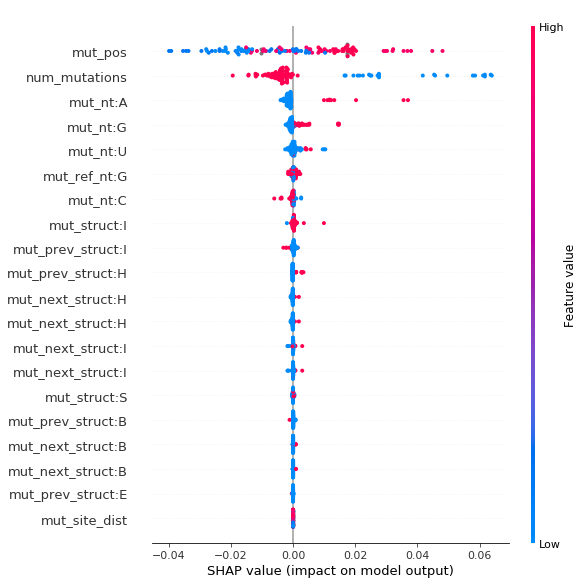

Contribution/Total:0.15175386
['site_prev_nt*', 'site_next_nt*', 'site_struct*', 'site_prev_struct*', 'site_next_struct*', 'site_1_1*', 'site_length*', 'site_length_stem*', 'site_length_hairpin*', 'site_length_bulge*', 'site_length_internal_es*', 'site_length_internal_ecs*', 'site_5prm_cp_hairpin*', 'site_5prm_cp_bulge*', 'site_3prm_cp_bulge*', 'site_5prm_cp_internal*', 'site_3prm_cp_internal*']


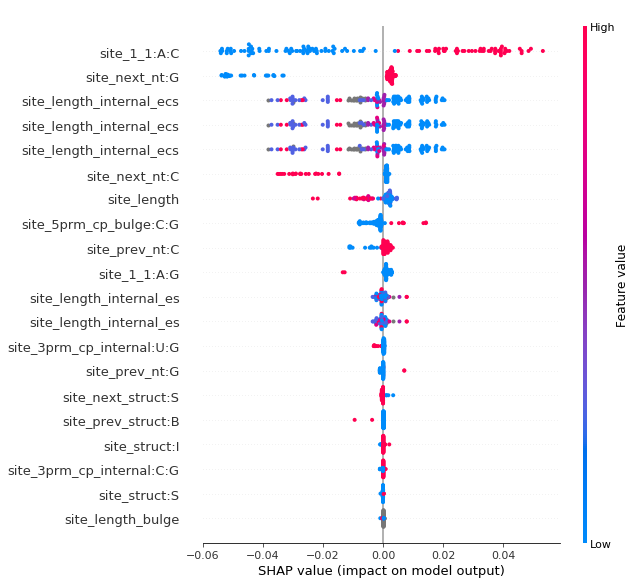

Contribution/Total:0.41882187
['u_count*', 'u_all_stem_length*', 'u_hairpin_length*', 'u1_exist*', 'u1_distance*', 'u1_struct*', 'u1_length*', 'u1_length_stem*', 'u1_length_hairpin*', 'u1_length_bulge*', 'u1_length_internal_es*', 'u1_length_internal_ecs*', 'u1_5prm_cp_hairpin*', 'u1_5prm_cp_bulge*', 'u1_3prm_cp_bulge*', 'u1_5prm_cp_internal*', 'u1_3prm_cp_internal*', 'u2_exist*', 'u2_distance*', 'u2_struct*', 'u2_length*', 'u2_length_stem*', 'u2_length_hairpin*', 'u2_length_bulge*', 'u2_length_internal_es*', 'u2_length_internal_ecs*', 'u2_5prm_cp_hairpin*', 'u2_5prm_cp_bulge*', 'u2_3prm_cp_bulge*', 'u2_5prm_cp_internal*', 'u2_3prm_cp_internal*', 'u3_exist*', 'u3_distance*', 'u3_struct*', 'u3_length*', 'u3_length_stem*', 'u3_length_hairpin*', 'u3_length_bulge*', 'u3_length_internal_es*', 'u3_length_internal_ecs*', 'u3_5prm_cp_hairpin*', 'u3_5prm_cp_bulge*', 'u3_3prm_cp_bulge*', 'u3_5prm_cp_internal*', 'u3_3prm_cp_internal*']


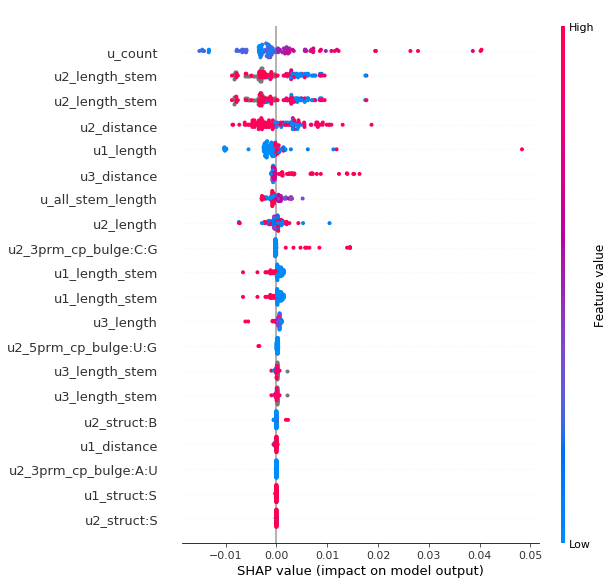

Contribution/Total:0.1207961
['d_count*', 'd_all_stem_length*', 'd1_exist*', 'd1_distance*', 'd1_struct*', 'd1_length*', 'd1_length_stem*', 'd1_length_hairpin*', 'd1_length_bulge*', 'd1_length_internal_es*', 'd1_length_internal_ecs*', 'd1_5prm_cp_hairpin*', 'd1_5prm_cp_bulge*', 'd1_3prm_cp_bulge*', 'd1_5prm_cp_internal*', 'd1_3prm_cp_internal*', 'd2_exist*', 'd2_distance*', 'd2_struct*', 'd2_length*', 'd2_length_stem*', 'd2_length_hairpin*', 'd2_length_bulge*', 'd2_length_internal_es*', 'd2_length_internal_ecs*', 'd2_5prm_cp_hairpin*', 'd2_5prm_cp_bulge*', 'd2_3prm_cp_bulge*', 'd2_5prm_cp_internal*', 'd2_3prm_cp_internal*', 'd3_exist*', 'd3_distance*', 'd3_struct*', 'd3_length*', 'd3_length_stem*', 'd3_length_hairpin*', 'd3_length_bulge*', 'd3_length_internal_es*', 'd3_length_internal_ecs*', 'd3_5prm_cp_hairpin*', 'd3_5prm_cp_bulge*', 'd3_3prm_cp_bulge*', 'd3_5prm_cp_internal*', 'd3_3prm_cp_internal*']


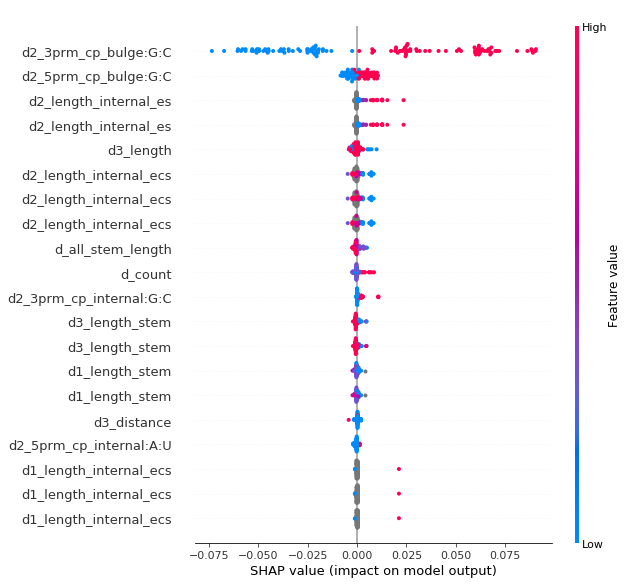

Contribution/Total:0.28882796
['u_count*', 'u_all_stem_length*', 'u_hairpin_length*', 'u1_exist*', 'u1_distance*', 'u1_struct*', 'u1_length*', 'u1_length_stem*', 'u1_length_hairpin*', 'u1_length_bulge*', 'u1_length_internal_es*', 'u1_length_internal_ecs*', 'u1_5prm_cp_hairpin*', 'u1_5prm_cp_bulge*', 'u1_3prm_cp_bulge*', 'u1_5prm_cp_internal*', 'u1_3prm_cp_internal*', 'u2_exist*', 'u2_distance*', 'u2_struct*', 'u2_length*', 'u2_length_stem*', 'u2_length_hairpin*', 'u2_length_bulge*', 'u2_length_internal_es*', 'u2_length_internal_ecs*', 'u2_5prm_cp_hairpin*', 'u2_5prm_cp_bulge*', 'u2_3prm_cp_bulge*', 'u2_5prm_cp_internal*', 'u2_3prm_cp_internal*', 'u3_exist*', 'u3_distance*', 'u3_struct*', 'u3_length*', 'u3_length_stem*', 'u3_length_hairpin*', 'u3_length_bulge*', 'u3_length_internal_es*', 'u3_length_internal_ecs*', 'u3_5prm_cp_hairpin*', 'u3_5prm_cp_bulge*', 'u3_3prm_cp_bulge*', 'u3_5prm_cp_internal*', 'u3_3prm_cp_internal*', 'd_count*', 'd_all_stem_length*', 'd1_exist*', 'd1_distance*',

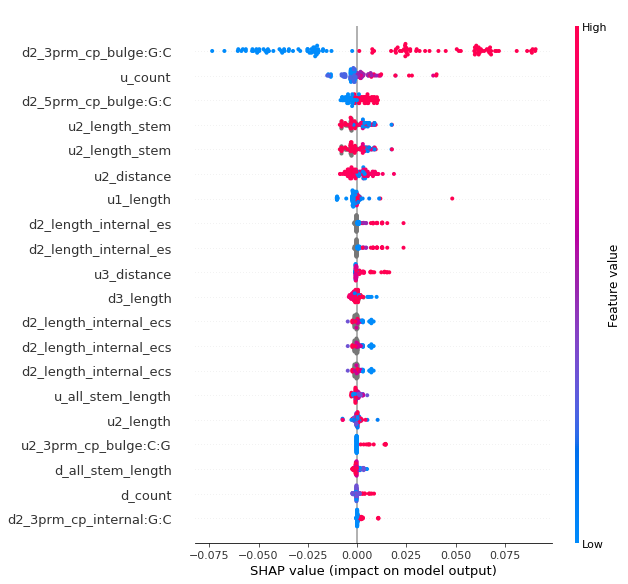

Contribution/Total:0.409624
['num_mutations*', 'mut_pos*', 'mut_site_dist*', 'mut_ref_nt*', 'mut_nt*', 'mut_struct*', 'mut_ref_struct*', 'mut_prev_struct*', 'mut_next_struct*', 'mut_same_as_site*', 'site_prev_nt*', 'site_next_nt*', 'site_struct*', 'site_prev_struct*', 'site_next_struct*', 'site_1_1*', 'site_length*', 'site_length_stem*', 'site_length_hairpin*', 'site_length_bulge*', 'site_length_internal_es*', 'site_length_internal_ecs*', 'site_5prm_cp_hairpin*', 'site_5prm_cp_bulge*', 'site_3prm_cp_bulge*', 'site_5prm_cp_internal*', 'site_3prm_cp_internal*']


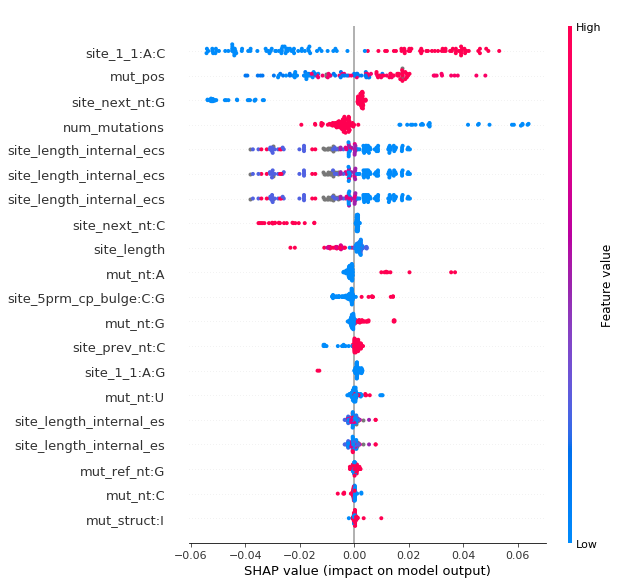

Contribution/Total:0.5705757
['all_stem_length', 'free_energy*', 'sim_nor_score*', 'probability_active_conf*', 'num_mutations*', 'mut_pos*', 'mut_site_dist*', 'mut_ref_nt*', 'mut_nt*', 'mut_struct*', 'mut_ref_struct*', 'mut_prev_struct*', 'mut_next_struct*', 'mut_same_as_site*', 'site_prev_nt*', 'site_next_nt*', 'site_struct*', 'site_prev_struct*', 'site_next_struct*', 'site_1_1*', 'site_length*', 'site_length_stem*', 'site_length_hairpin*', 'site_length_bulge*', 'site_length_internal_es*', 'site_length_internal_ecs*', 'site_5prm_cp_hairpin*', 'site_5prm_cp_bulge*', 'site_3prm_cp_bulge*', 'site_5prm_cp_internal*', 'site_3prm_cp_internal*', 'd_count*', 'd_all_stem_length*', 'd1_exist*', 'd1_distance*', 'd1_struct*', 'd1_length*', 'd1_length_stem*', 'd1_length_hairpin*', 'd1_length_bulge*', 'd1_length_internal_es*', 'd1_length_internal_ecs*', 'd1_5prm_cp_hairpin*', 'd1_5prm_cp_bulge*', 'd1_3prm_cp_bulge*', 'd1_5prm_cp_internal*', 'd1_3prm_cp_internal*', 'd2_exist*', 'd2_distance*', 'd2_s

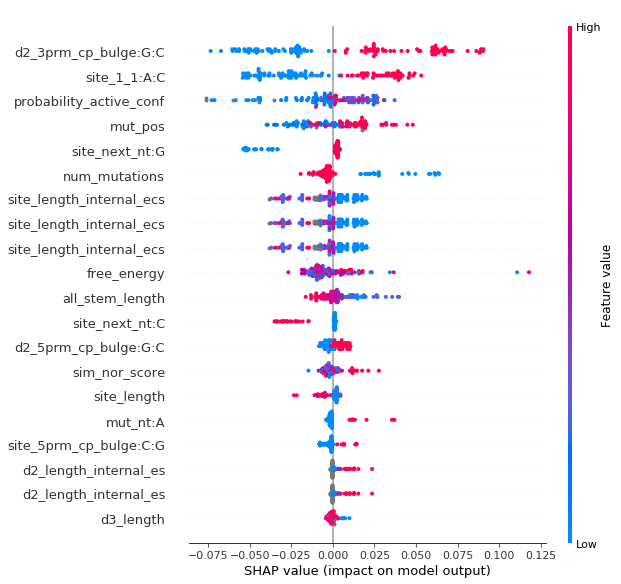

Contribution/Total:1.0457609
['all_stem_length', 'free_energy*', 'sim_nor_score*', 'probability_active_conf*', 'num_mutations*', 'mut_pos*', 'mut_site_dist*', 'mut_ref_nt*', 'mut_nt*', 'mut_struct*', 'mut_ref_struct*', 'mut_prev_struct*', 'mut_next_struct*', 'mut_same_as_site*', 'site_prev_nt*', 'site_next_nt*', 'site_struct*', 'site_prev_struct*', 'site_next_struct*', 'site_1_1*', 'site_length*', 'site_length_stem*', 'site_length_hairpin*', 'site_length_bulge*', 'site_length_internal_es*', 'site_length_internal_ecs*', 'site_5prm_cp_hairpin*', 'site_5prm_cp_bulge*', 'site_3prm_cp_bulge*', 'site_5prm_cp_internal*', 'site_3prm_cp_internal*', 'u_count*', 'u_all_stem_length*', 'u_hairpin_length*', 'u1_exist*', 'u1_distance*', 'u1_struct*', 'u1_length*', 'u1_length_stem*', 'u1_length_hairpin*', 'u1_length_bulge*', 'u1_length_internal_es*', 'u1_length_internal_ecs*', 'u1_5prm_cp_hairpin*', 'u1_5prm_cp_bulge*', 'u1_3prm_cp_bulge*', 'u1_5prm_cp_internal*', 'u1_3prm_cp_internal*', 'u2_exist*', 

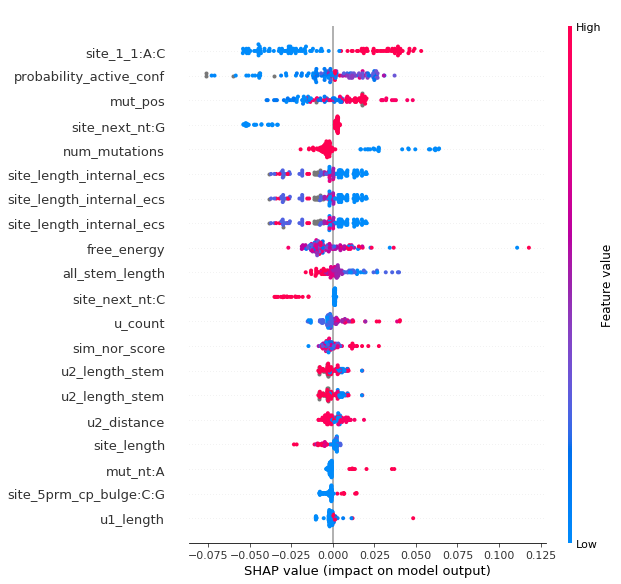

Contribution/Total:0.87772906
['site_struct*', 'site_prev_struct*', 'site_next_struct*', 'site_1_1*', 'site_length*', 'site_length_stem*', 'site_length_hairpin*', 'site_length_bulge*', 'site_length_internal_es*', 'site_length_internal_ecs*', 'site_5prm_cp_hairpin*', 'site_5prm_cp_bulge*', 'site_3prm_cp_bulge*', 'site_5prm_cp_internal*', 'site_3prm_cp_internal*']


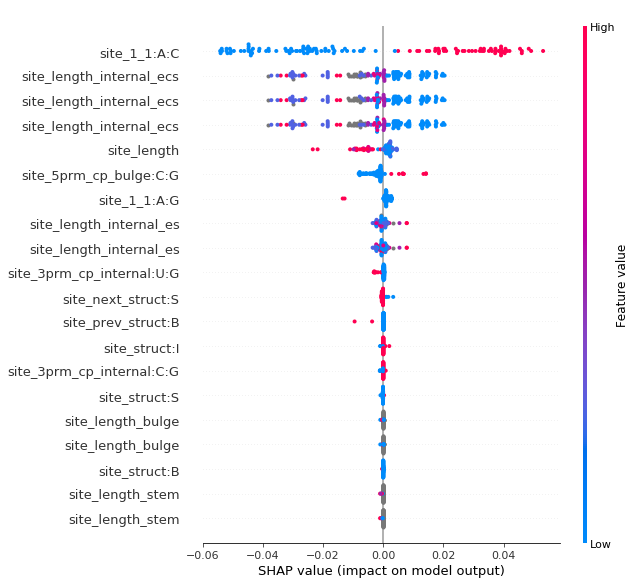

Contribution/Total:0.3256829
['site_prev_nt*', 'site_next_nt*']


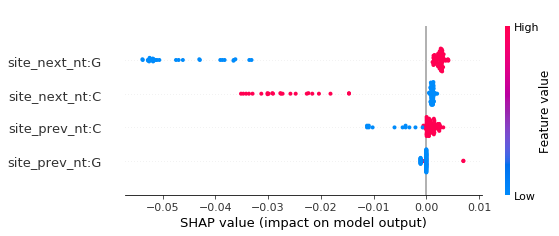

Contribution/Total:0.093139
['mut_pos*', 'mut_site_dist*', 'mut_ref_nt*', 'mut_nt*']


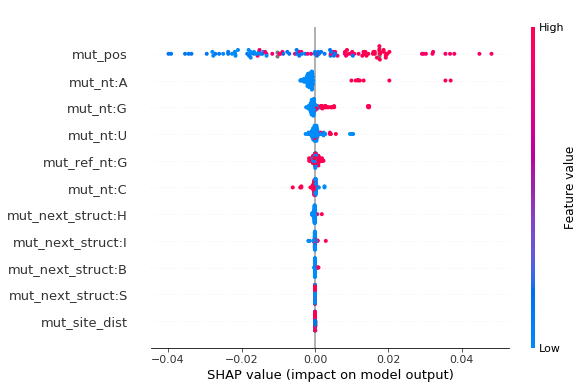

Contribution/Total:0.09540748
['mut_pos*', 'mut_site_dist*', 'mut_ref_nt*', 'mut_nt*', 'site_prev_nt*', 'site_next_nt*']


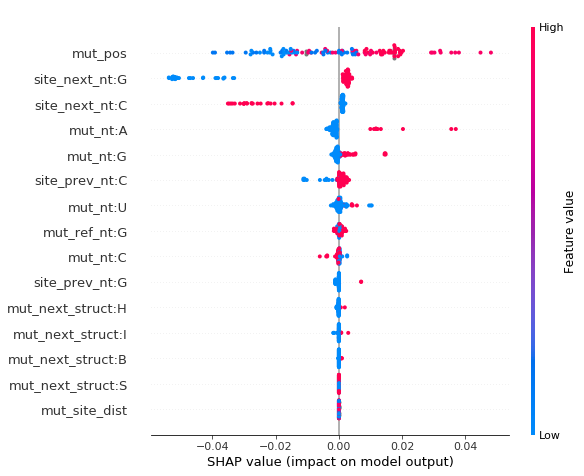

Contribution/Total:0.18854648
['all_stem_length', 'free_energy*', 'sim_nor_score*', 'probability_active_conf*', 'site_prev_nt*', 'site_next_nt*', 'site_struct*', 'site_prev_struct*', 'site_next_struct*', 'site_1_1*', 'site_length*', 'site_length_stem*', 'site_length_hairpin*', 'site_length_bulge*', 'site_length_internal_es*', 'site_length_internal_ecs*', 'site_5prm_cp_hairpin*', 'site_5prm_cp_bulge*', 'site_3prm_cp_bulge*', 'site_5prm_cp_internal*', 'site_3prm_cp_internal*', 'u_count*', 'u_all_stem_length*', 'u_hairpin_length*', 'u1_exist*', 'u1_distance*', 'u1_struct*', 'u1_length*', 'u1_length_stem*', 'u1_length_hairpin*', 'u1_length_bulge*', 'u1_length_internal_es*', 'u1_length_internal_ecs*', 'u1_5prm_cp_hairpin*', 'u1_5prm_cp_bulge*', 'u1_3prm_cp_bulge*', 'u1_5prm_cp_internal*', 'u1_3prm_cp_internal*', 'u2_exist*', 'u2_distance*', 'u2_struct*', 'u2_length*', 'u2_length_stem*', 'u2_length_hairpin*', 'u2_length_bulge*', 'u2_length_internal_es*', 'u2_length_internal_ecs*', 'u2_5prm_c

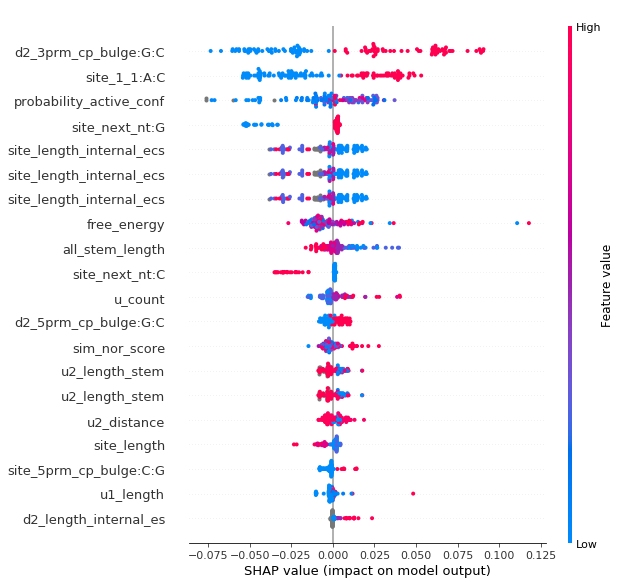

Contribution/Total:1.0148032
['all_stem_length', 'free_energy*', 'sim_nor_score*', 'probability_active_conf*']


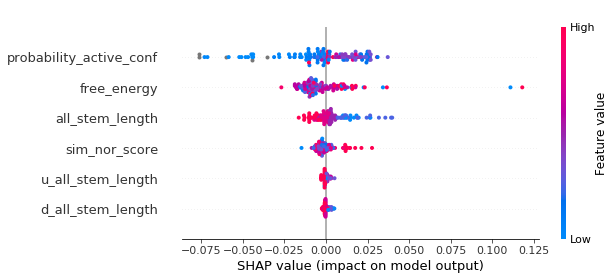

Contribution/Total:0.1863572


In [85]:
from feature_subsets import * 
subset_names=["mut","site","u","d","u_d","mut_site","no_up","no_down","site_struct","site_seq","mut_seq","mut_seq_site","no_mut","overall_structure"]
subset_contribs=[]
for subset in [mut,site,u,d,u_d,mut_site,no_up,no_down,site_struct,site_seq,mut_seq,mut_seq_site,no_mut,overall_structure]: 
  print(subset)
  cur_features=filter_features(shap_values,subset)
  cur_feature_shap=shap_values[cur_features].values 
  cur_feature_data_X=test_X[cur_features]
  shap.summary_plot(cur_feature_shap, cur_feature_data_X)#,sort=False,max_display=50)
  contrib=shap_contribs_subgroup(shap_values,subset)
  subset_contribs.append(contrib)
  print("Contribution/Total:"+str(contrib))

In [86]:
subset_contrib_df=pd.DataFrame({'Subset':subset_names,
                               'Contribution':[100*i for i in subset_contribs]})

In [87]:
subset_contrib_df=subset_contrib_df.sort_values(by=['Contribution'],ascending=False)
subset_contrib_df.reset_index(inplace=True, drop=True) 

In [88]:
from pandas.api.types import CategoricalDtype

In [89]:
subset_cat = CategoricalDtype(categories=list(subset_contrib_df['Subset']), ordered=True)

# Cast the existing categories into the new category. Due to a bug in pandas
# we need to do this via a string.
subset_contrib_df['Subset_Cat'] = subset_contrib_df['Subset'].astype(str).astype(subset_cat)


In [90]:
subset_contrib_df
subset_contrib_df.to_csv('TTYH2.comp.subset.importance.csv')

/home/anna/.local/lib/python3.6/site-packages/plotnine/ggplot.py:706: UserWarning:

Saving 5 x 4 in image.

/home/anna/.local/lib/python3.6/site-packages/plotnine/ggplot.py:707: UserWarning:

Filename: TTYH2.comp.subset.importance.svg



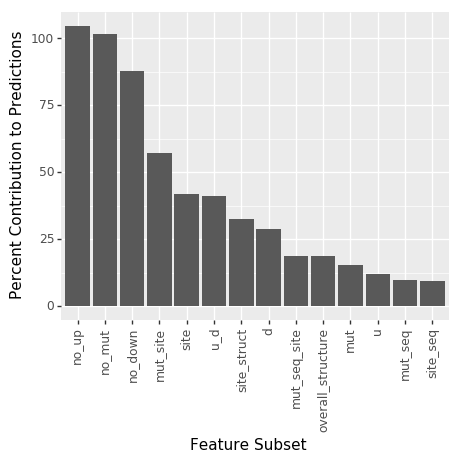

<ggplot: (8773710866310)>

In [91]:
p=(ggplot(subset_contrib_df, aes('Subset_Cat', 'Contribution'))
 + geom_bar(stat='identity')
 + xlab("Feature Subset")
 + ylab("Percent Contribution to Predictions")
 + theme(axis_text_x=element_text(angle=90))
)
ggsave(plot=p, filename='TTYH2.comp.subset.importance.svg',width=5,height=4,units='in')
p

## No "mut" features

In [92]:
## Read in the data 
import pandas as pd 
import feature_subsets
data=pd.read_csv("../xin_feature_matrices/ttyh2_bc_degenerate_computational.features.csv",header=0,sep=',',index_col=0)
#drop all mut features
cur_features=filter_features(data,feature_subsets.mut)
cur_features.remove('mut_pos')
data=data.drop(cur_features,axis=1)
data.head

<bound method NDFrame.head of         editing_value  free_energy  sim_nor_score  mut_exist  mut_type  \
rna_id                                                                   
DG0001         0.8710       -88.46         0.8798          1  mismatch   
DG0001         0.8710       -88.46         0.8798          1  mismatch   
DG0001         0.8710       -88.46         0.8798          1  mismatch   
DG0001         0.8710       -88.46         0.8798          1  mismatch   
DG0001         0.8710       -88.46         0.8798          1  mismatch   
DG0002         0.4685       -87.80         1.0000          1  mismatch   
DG0003         0.4750       -86.09         0.9054          1  mismatch   
DG0004         0.4320       -91.62         0.8571          1  mismatch   
DG0005         0.4280       -87.05         1.0000          0        wt   
DG0006         0.4190       -79.98         0.8386          1  mismatch   
DG0006         0.4190       -79.98         0.8386          1  mismatch   
DG0006  

In [93]:
#remove any null editing level values 
data=data[~data["editing_value"].isnull().values]

In [94]:
data=format_for_xgboost(data)
train_split,eval_split,test_split=split_train_test_eval_by_mut_pos(data)

(363, 147)
{24.0: 32, 25.0: 33, 26.0: 41, 27.0: 42, 28.0: 31, 29.0: 23, 30.0: 24, 31.0: 34, 32.0: 25, 33.0: 21, 48.0: 37, 67.0: 20}


In [95]:
#Remove any non-varying features 
train_novar=get_singleval_features(train_split)
eval_novar=get_singleval_features(eval_split)
test_novar=get_singleval_features(test_split)
uniform_features_to_drop=list(set(train_novar+eval_novar+test_novar))

In [96]:
#Remove any null features 
train_null=get_all_null_features(train_split)
eval_null=get_all_null_features(eval_split)
test_null=get_all_null_features(test_split)
null_features_to_drop=list(set(train_null+eval_null+test_null))

In [97]:
to_drop=list(set(uniform_features_to_drop+null_features_to_drop))
to_drop.append("mut_pos")
print("\n".join(to_drop))

u2_exist
d3_length_internal_es
u1_5prm_cp_internal
u3_length_internal_ecs
d1_5prm_cp_hairpin
u3_5prm_cp_internal
d2_5prm_cp_hairpin
u1_length_internal_ecs
u3_length_internal_es
site_prev_nt:C
mut_exist
d3_length_bulge
u2_3prm_cp_internal
mut_type:mismatch
d3_5prm_cp_bulge
u1_exist
site_5prm_cp_hairpin
u3_5prm_cp_bulge:G:C
site_3prm_cp_internal:A:U
u1_length_hairpin
d2_5prm_cp_internal:G:C
d3_3prm_cp_bulge
u2_length_internal_es
site_length_hairpin
d2_length_hairpin
u2_length_internal_ecs
d1_length_hairpin
u3_3prm_cp_internal
d2_exist
u1_3prm_cp_internal
u1_length_internal_es
d2_3prm_cp_bulge:G:U
d3_3prm_cp_internal
site_3prm_cp_internal:U:G
d1_exist
u1_5prm_cp_hairpin
u3_exist
d3_5prm_cp_internal
u3_length_bulge
d3_length_hairpin
d3_length_internal_ecs
u3_3prm_cp_bulge:G:C
site_3prm_cp_internal:G:U
u_hairpin_length
d2_3prm_cp_bulge:G:C
d3_5prm_cp_hairpin
site_next_nt:G
u3_struct:B
mut_type:wt
u2_5prm_cp_internal
mut_pos


In [98]:
train_split=train_split.drop(to_drop,axis=1)
eval_split=eval_split.drop(to_drop,axis=1)
test_split=test_split.drop(to_drop,axis=1)

In [99]:
train_y=train_split['editing_value']
train_X=train_split.drop(['editing_value'],axis=1)

eval_y=eval_split['editing_value']
eval_X=eval_split.drop(['editing_value'],axis=1)

test_y=test_split['editing_value']
test_X=test_split.drop(['editing_value'],axis=1)

In [100]:
print(train_X.shape)
print(train_y.shape)
print(eval_X.shape)
print(eval_y.shape)
print(test_X.shape)
print(test_y.shape)


(241, 95)
(241,)
(65, 95)
(65,)
(56, 95)
(56,)


In [101]:
## format matrixes for xgboost 
dtrain=xgboost.DMatrix(train_X,train_y)
deval=xgboost.DMatrix(eval_X,eval_y)
dtest=xgboost.DMatrix(test_X,test_y)

In [102]:
## set model training parameters 
param=dict() 
param['nthread'] = 20
#rmse -- root mean square error 
# mae -- mean absolute error 
# map -- mean average precision 
# auc -- area under ROC curve 
# aucpr -- area under precision recall curve 
param['eval_metric'] = ['auc','mae','map','aucpr','rmse']

In [103]:
evallist = [(deval, 'eval'), (dtrain, 'train')]


In [104]:
num_round = 1000
bst = xgboost.train(param, dtrain, num_round, evallist,early_stopping_rounds=10)

[0]	eval-auc:0.731401	eval-mae:0.325515	eval-map:1	eval-aucpr:0.42788	eval-rmse:0.332467	train-auc:0.891411	train-mae:0.304492	train-map:1	train-aucpr:0.550522	train-rmse:0.318165
Multiple eval metrics have been passed: 'train-rmse' will be used for early stopping.

Will train until train-rmse hasn't improved in 10 rounds.
[1]	eval-auc:0.731849	eval-mae:0.23296	eval-map:1	eval-aucpr:0.432453	eval-rmse:0.235767	train-auc:0.892355	train-mae:0.214981	train-map:1	train-aucpr:0.554132	train-rmse:0.224737
[2]	eval-auc:0.731849	eval-mae:0.167681	eval-map:1	eval-aucpr:0.432453	eval-rmse:0.169913	train-auc:0.892331	train-mae:0.151524	train-map:1	train-aucpr:0.55405	train-rmse:0.159214
[3]	eval-auc:0.731849	eval-mae:0.121904	eval-map:1	eval-aucpr:0.432453	eval-rmse:0.126169	train-auc:0.892442	train-mae:0.107077	train-map:1	train-aucpr:0.554638	train-rmse:0.113244
[4]	eval-auc:0.747848	eval-mae:0.089522	eval-map:1	eval-aucpr:0.44614	eval-rmse:0.097906	train-auc:0.905788	train-mae:0.076241	train-m

In [106]:
# save to binary file for faster loading
bst.save_model('ttyh2.computational.model')
# save model to text file 
bst.dump_model('ttyh2.computational.raw.txt')


In [107]:
## get model predictions on the test, training, and eval splits 
test_pred = bst.predict(dtest)
train_pred=bst.predict(dtrain)
eval_pred=bst.predict(deval)

In [108]:
## Correlation values 
from scipy.stats import spearmanr,pearsonr
spearman_train=spearmanr(train_y,train_pred)
spearman_eval=spearmanr(eval_y,eval_pred)
spearman_test=spearmanr(test_y,test_pred)

pearson_train=pearsonr(train_y,train_pred)
pearson_eval=pearsonr(eval_y,eval_pred)
pearson_test=pearsonr(test_y,test_pred)

print("Spearman correlation:")
print("Train:"+str(spearman_train))
print("Eval:"+str(spearman_eval))
print("Test:"+str(spearman_test))
print("\n")
print("Pearson correlation:")
print("Train:"+str(pearson_train))
print("Eval:"+str(pearson_eval))
print("Test:"+str(pearson_test))

Spearman correlation:
Train:SpearmanrResult(correlation=0.9982263938875616, pvalue=7.560048679288557e-295)
Eval:SpearmanrResult(correlation=0.9443888584097792, pvalue=3.925135006420672e-32)
Test:SpearmanrResult(correlation=0.9975708057559444, pvalue=3.595759421026803e-64)


Pearson correlation:
Train:(0.999986237400765, 0.0)
Eval:(0.8767459411858302, 1.0670765547099967e-21)
Test:(0.9919214132740567, 4.126041968513111e-50)


In [109]:
## MAE
from sklearn.metrics import mean_absolute_error
mae_train=mean_absolute_error(train_y,train_pred)
print("MAE Train:"+str(mae_train))

mae_eval=mean_absolute_error(eval_y,eval_pred)
print("MAE Eval:"+str(mae_eval))

mae_test=mean_absolute_error(test_y,test_pred)
print("MAE Test:"+str(mae_test))


MAE Train:0.00037721208123590676
MAE Eval:0.011741707542624612
MAE Test:0.0058463979618889935


In [110]:
## MAPE
pseudocount=0.01
mape_train=np.mean(np.abs((train_y - train_pred) /(pseudocount+train_y))) * 100
print("MAPE Train:"+str(mape_train)+"%")

mape_eval=np.mean(np.abs((eval_y - eval_pred) /(pseudocount+eval_y))) * 100
print("MAPE Eval:"+str(mape_eval)+"%")

mape_test=np.mean(np.abs((test_y - test_pred) /(pseudocount+test_y))) * 100
print("MAPE Test:"+str(mape_test)+"%")

MAPE Train:1.2430268981453079%
MAPE Eval:4.478690923404781%
MAPE Test:3.2640035584704026%


In [111]:
## RMSE
from sklearn.metrics import mean_squared_error
import math 
rmse_train=math.sqrt(mean_squared_error(train_y,train_pred))
print("RMSE Train:"+str(rmse_train))

rmse_eval=math.sqrt(mean_squared_error(eval_y,eval_pred))
print("RMSE Eval:"+str(rmse_eval))

rmse_test=math.sqrt(mean_squared_error(test_y,test_pred))
print("RMSE Test:"+str(rmse_test))


RMSE Train:0.0008868773984451558
RMSE Eval:0.0650183027552947
RMSE Test:0.026578262908425635


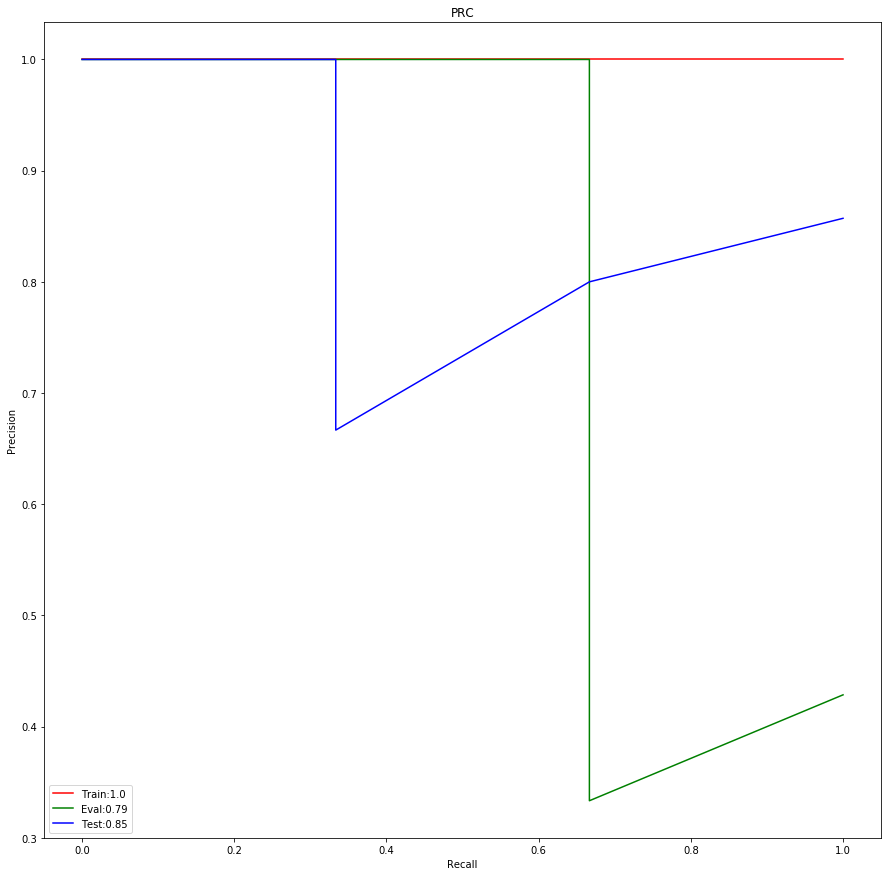

In [112]:
## PRC 
## PRC only valid for binary outcomes. 
## Editing levels < 0.4 are labeled as "0". 
## Editing levels >= 0.4 are labeled as "1". 

from sklearn.metrics import auc, precision_recall_curve

precision_train,recall_train,prc_thresholds_train=precision_recall_curve(train_y>=0.4,train_pred)
precision_eval,recall_eval,prc_thresholds_eval=precision_recall_curve(eval_y>=0.4,eval_pred)
precision_test,recall_test,prc_thresholds_test=precision_recall_curve(test_y>=0.4,test_pred)

auprc_train=auc(recall_train,precision_train)
auprc_eval=auc(recall_eval,precision_eval)
auprc_test=auc(recall_test,precision_test)

plt.plot(recall_train,precision_train,'r',label="Train:"+str(round(auprc_train,2)))
plt.plot(recall_eval,precision_eval,'g',label="Eval:"+str(round(auprc_eval,2)))
plt.plot(recall_test,precision_test,'b',label="Test:"+str(round(auprc_test,2)))
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("PRC")
plt.legend()

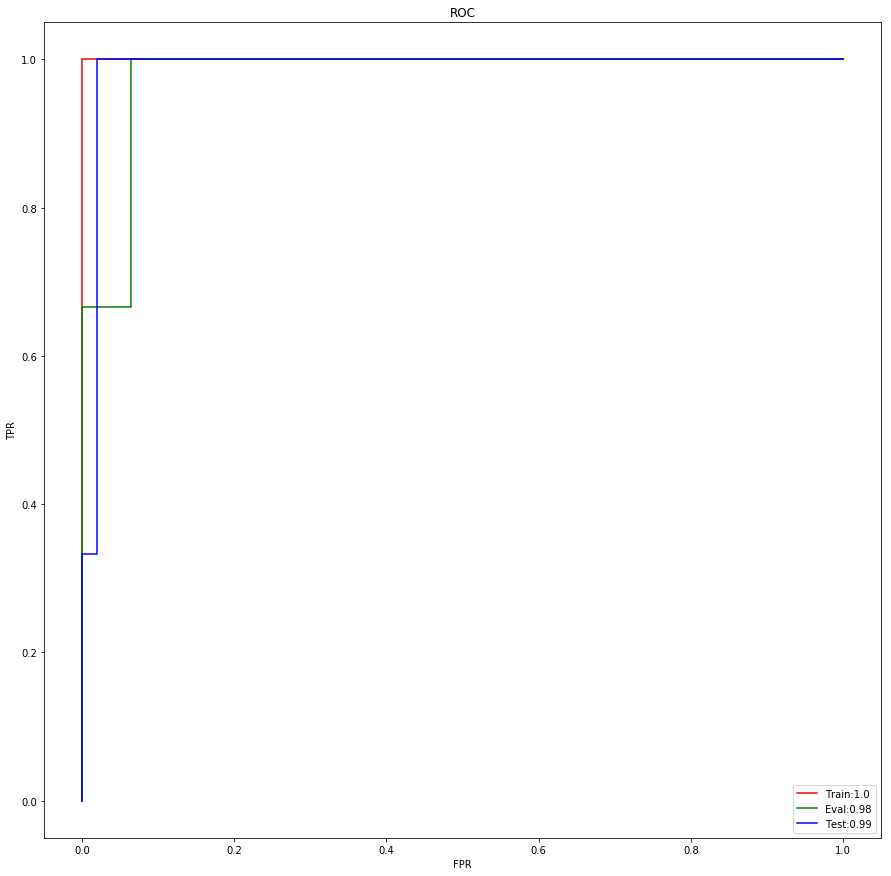

In [113]:
## ROC
from sklearn.metrics import roc_curve, roc_auc_score
fpr_train,tpr_train,roc_thresholds_train=roc_curve(train_y>=0.4,train_pred)
fpr_eval,tpr_eval,roc_thresholds_eval=roc_curve(eval_y>=0.4,eval_pred)
fpr_test,tpr_test,roc_thresholds_test=roc_curve(test_y>=0.4,test_pred)

auroc_train=roc_auc_score(train_y>=0.4,train_pred)
auroc_eval=roc_auc_score(eval_y>=0.4,eval_pred)
auroc_test=roc_auc_score(test_y>=0.4,test_pred)

plt.plot(fpr_train,tpr_train,'r',label="Train:"+str(round(auroc_train,2)))
plt.plot(fpr_eval,tpr_eval,'g',label="Eval:"+str(round(auroc_eval,2)))
plt.plot(fpr_test,tpr_test,'b',label="Test:"+str(round(auroc_test,2)))
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC")
plt.legend()

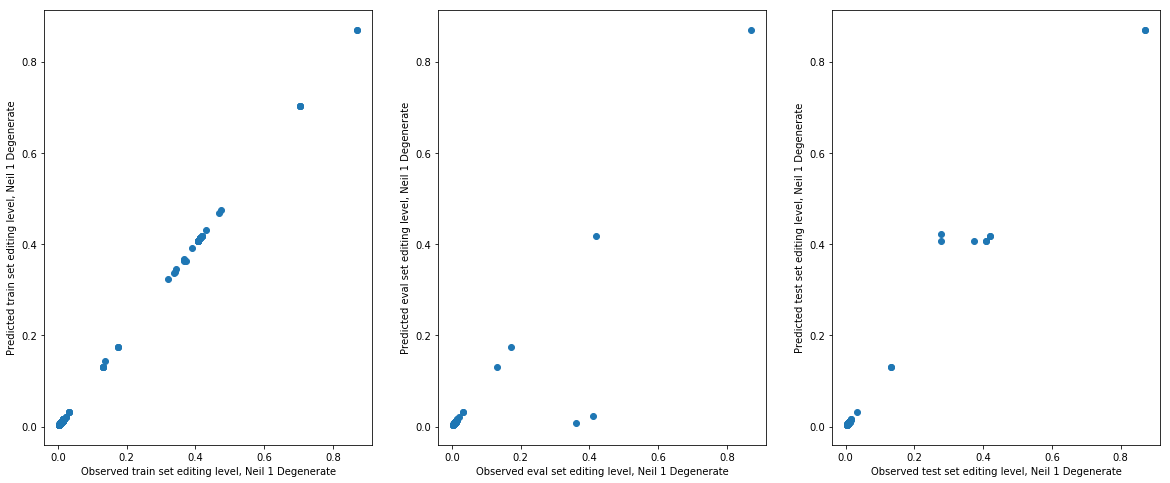

In [114]:
#plot the test set predictions 
matplotlib.rcParams['figure.figsize'] = [20, 8]
plt.subplot(1,3,1)
plt.plot(list(train_y),list(train_pred),'o')
plt.xlabel("Observed train set editing level, Neil 1 Degenerate")
plt.ylabel("Predicted train set editing level, Neil 1 Degenerate")
plt.subplot(1,3,2)
plt.plot(list(eval_y),list(eval_pred),'o')
plt.xlabel("Observed eval set editing level, Neil 1 Degenerate")
plt.ylabel("Predicted eval set editing level, Neil 1 Degenerate")
plt.subplot(1,3,3)
plt.plot(list(test_y),list(test_pred),'o')
plt.xlabel("Observed test set editing level, Neil 1 Degenerate")
plt.ylabel("Predicted test set editing level, Neil 1 Degenerate")

plt.show()

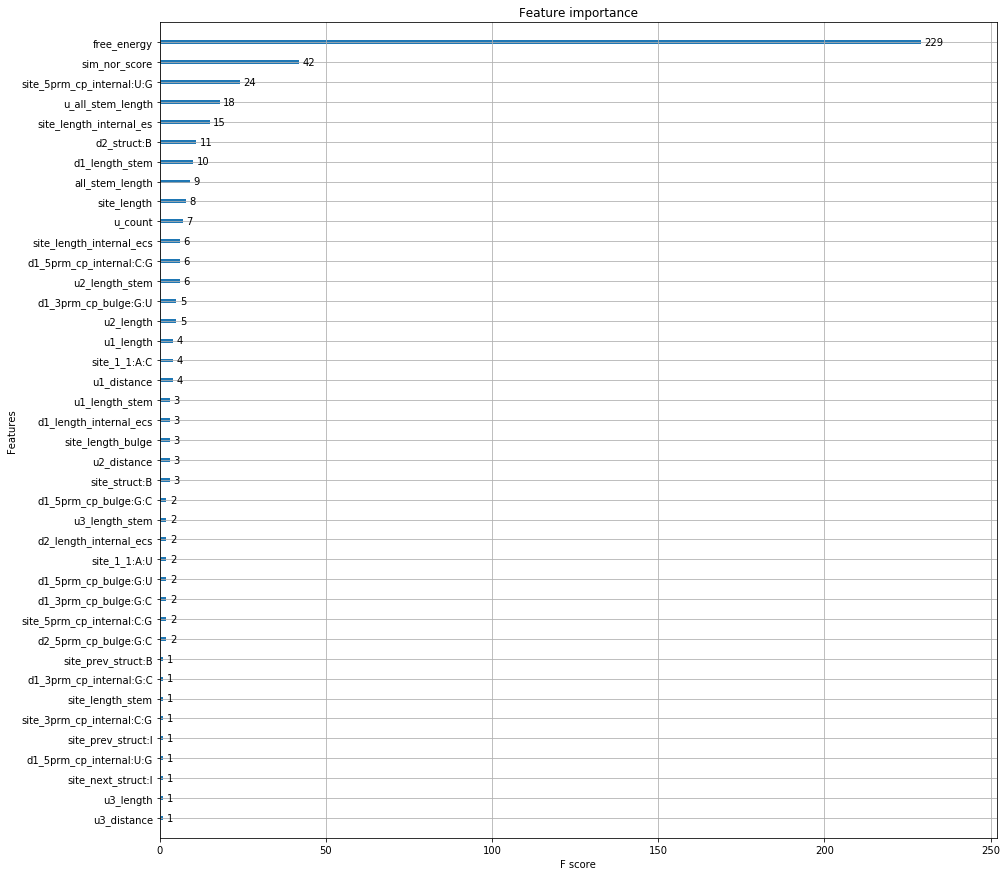

In [115]:
matplotlib.rcParams['figure.figsize'] = [15, 15]
xgboost.plot_importance(bst)

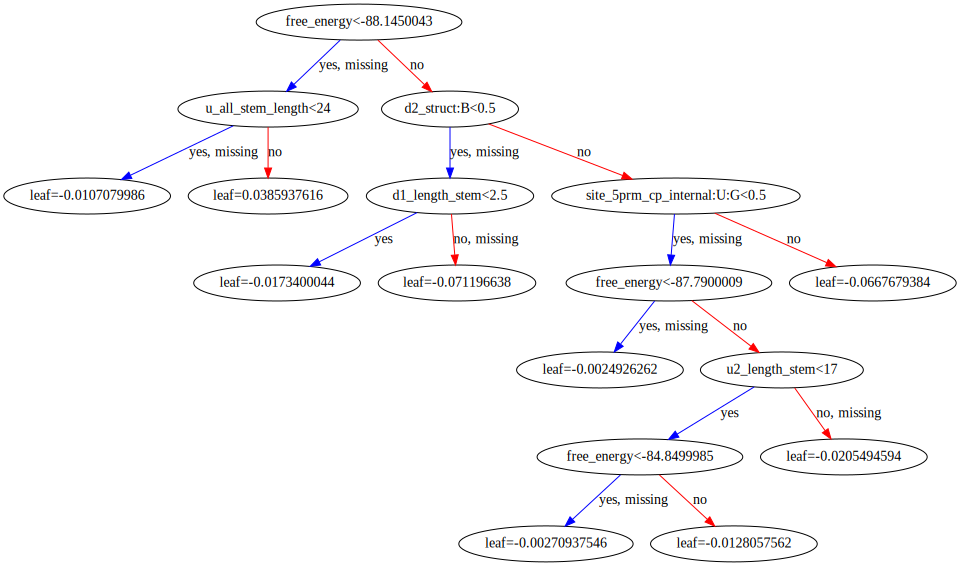

In [116]:
xgboost.to_graphviz(bst, num_trees=2)


In [117]:
# explain the model's predictions using SHAP values
explainer = shap.TreeExplainer(bst)
shap_values = explainer.shap_values(test_X)
shap_values.shape

(56, 95)

In [118]:
test_y=pd.DataFrame(test_y)
max_index=test_y.index[test_y['editing_value'] == max(test_y['editing_value'])]
max_row=test_y.index.get_loc(max_index[0])
# visualize prediction for isoform with the highest editing level 
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[max_row,:], test_X.iloc[max_row,:])

In [119]:
# visualize prediction for isoform with the lowest editing level 
shap.initjs()
min_index=test_y.index[test_y['editing_value'] == min(test_y['editing_value'])]
min_row=test_y.index.get_loc(min_index[0])
shap.force_plot(explainer.expected_value, shap_values[min_row,:], test_X.iloc[min_row,:])

In [120]:
# visualize the training set predictions
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values,train_X)

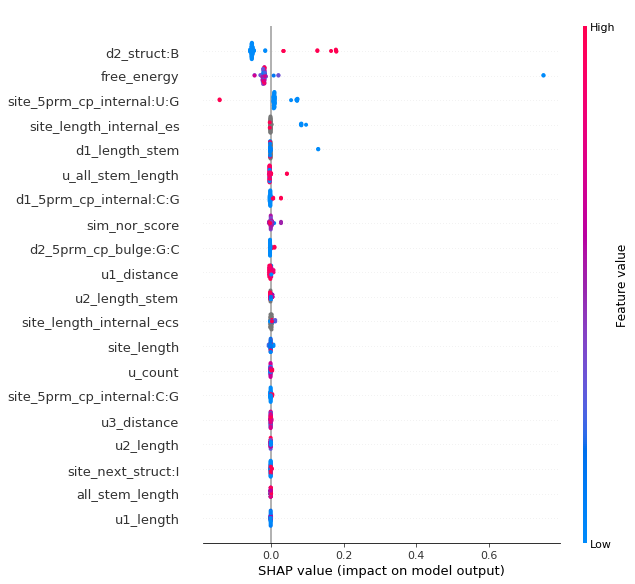

In [121]:
# summarize the effect of all the features 
shap.summary_plot(shap_values, test_X)


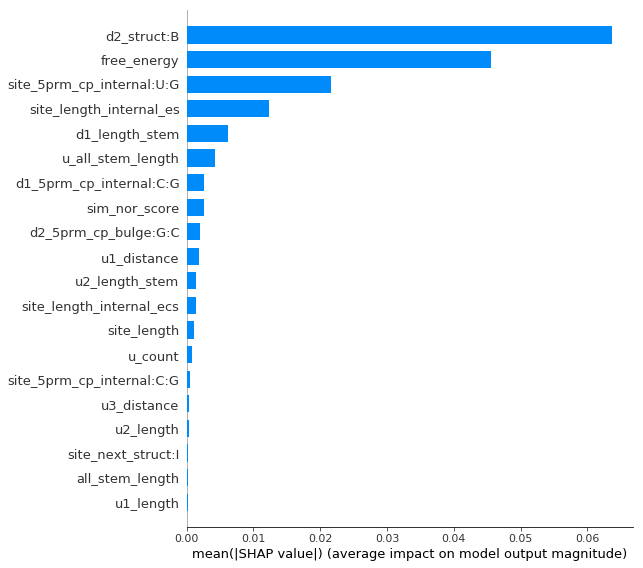

In [122]:
# We can also just take the mean absolute value of the SHAP values for each feature 
# to get a standard bar plot (produces stacked bars for multi-class outputs):
shap.summary_plot(shap_values, test_X, plot_type="bar")

In [123]:
## Compute pairwise interaction values from TreeShap
shap_interaction_values=explainer.shap_interaction_values(test_X)
shap_interaction_values.shape

(56, 95, 95)

In [124]:
##Average interaction values across the datapoints in the test set 
mean_interaction_values=np.mean(shap_interaction_values,axis=0)

In [125]:
Index=test_X.columns
Cols=test_X.columns
mean_interaction_values_df = pd.DataFrame(mean_interaction_values, index=Index, columns=Cols)

In [126]:
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)
configure_plotly_browser_state()

trace = Heatmap(z=mean_interaction_values_df.values,
                   x=Cols,
                   y=Index)
iplot([trace],show_link=False)
